# Imports

In [1]:
import sys
from pathlib import Path
from IPython.display import display

AVES_ROOT = Path("../..") if not "google.colab" in sys.modules else Path("aves_git")
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
mpl.rcParams["figure.dpi"] = 150
pd.options.display.max_columns = None
# esto depende de las fuentes que tengas instaladas en el sistema.
# mpl.rcParams["font.family"] = "Fira Sans Extra Condensed"

# Carga de Datos (EOD y areas verdes)

In [2]:
# Load
areas_verdes = (
    gpd.read_file(AVES_ROOT / "data" / "project" / "Superficie_de_Areas_Verdes_Santiago.geojson")
)
print("areas_verdes: \n", areas_verdes.columns)
print("crs: \n", areas_verdes.crs)

areas_verdes: 
 Index(['FID', 'comuna', 'estado', 'area_m2', 'area_ha', 'estado_2', 'id',
       'shapearea', 'layer', 'shape_leng', 'shape_area', 'clase',
       'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')
crs: 
 epsg:4326


In [3]:
areas_verdes["clase"].unique()

array(['PLAZA', 'BANDEJON', 'VEREDA', 'PARQUE', 'CAMPO DEPORTIVO',
       'AV PARQUE'], dtype=object)

In [4]:
from aves.data import eod
#load
EOD_PATH = AVES_ROOT / "data" / "external" / "EOD_STGO"

eod_hogares = eod.read_homes(EOD_PATH)
eod_personas = eod.read_people(EOD_PATH)
eod_viajes = eod.read_trips(EOD_PATH)

# Load
zones : gpd.GeoDataFrame = (
    gpd.read_file(AVES_ROOT / "data" / "processed" / "scl_zonas_urbanas.json")
    .set_index("ID")
    .to_crs(areas_verdes.crs)
)

# print columns
print("hogares: \n", eod_hogares.columns)
print("personas: \n", eod_personas.columns)
print("viajes: \n", eod_viajes.columns)
print("zonas: \n", zones.columns)

hogares: 
 Index(['Hogar', 'Sector', 'Zona', 'Comuna', 'DirCoordX', 'DirCoordY', 'Fecha',
       'DiaAsig', 'TipoDia', 'Temporada', 'NumPer', 'NumVeh', 'NumBicAdulto',
       'NumBicNino', 'Propiedad', 'MontoDiv', 'ImputadoDiv', 'MontoArr',
       'ImputadoArr', 'IngresoHogar', 'FactorHogar'],
      dtype='object')
personas: 
 Index(['Hogar', 'Persona', 'AnoNac', 'Sexo', 'Relacion', 'Viajes',
       'LicenciaConducir', 'PaseEscolar', 'AdultoMayor', 'Estudios', 'Curso',
       'Actividad', 'Ocupacion', 'ActividadEmpresa', 'JornadaTrabajo',
       'DondeEstudia', 'DirActividadCoordX', 'DirActividadCoordY',
       'DirEstudiosCoordX', 'DirEstudiosCoordY', 'NoViaja', 'TarjetaBip',
       'Tarjeta2Bip', 'MedioViajeRestricion', 'ConoceTransantiago',
       'NoUsaTransantiago', 'Discapacidad', 'TieneIngresos', 'Ingreso',
       'TramoIngreso', 'IngresoFinal', 'TramoIngresoFinal', 'IngresoImputado',
       'Factor_LaboralNormal', 'Factor_SabadoNormal', 'Factor_DomingoNormal',
       'Factor_La

## Arreglos a los datos

In [5]:
# fix comunas accents and uppercase
from gensim.utils import deaccent

zones["Comuna"] = zones["NOM_COMUNA"].str.upper()
zones["Comuna"] = zones["Comuna"].str.replace('Ñ', 'NN').map(deaccent).str.replace('NN', 'Ñ')

eod_viajes = eod_viajes[eod_viajes["ComunaOrigen"].notna() & eod_viajes["ComunaDestino"].notna()]
eod_viajes["ComunaOrigen"] = eod_viajes["ComunaOrigen"].str.upper()
eod_viajes["ComunaDestino"] = eod_viajes["ComunaDestino"].str.upper()

eod_viajes["ComunaOrigen"] = eod_viajes["ComunaOrigen"].str.replace('Ñ', 'NN').map(deaccent).str.replace('NN', 'Ñ')
eod_viajes["ComunaDestino"] = eod_viajes["ComunaDestino"].str.replace('Ñ', 'NN').map(deaccent).str.replace('NN', 'Ñ')

eod_hogares["Comuna"] = eod_hogares["Comuna"].str.upper()
eod_hogares["Comuna"] = eod_hogares["Comuna"].str.replace('Ñ', 'NN').map(deaccent).str.replace('NN', 'Ñ')

areas_verdes.rename(columns={"comuna": "Comuna"}, inplace=True)
areas_verdes["Comuna"] = areas_verdes["Comuna"].str.upper()
areas_verdes["Comuna"] = areas_verdes["Comuna"].str.replace('Ñ', 'NN').map(deaccent).str.replace('NN', 'Ñ')
# corregimos comunas con distinto nombre
areas_verdes["Comuna"] = areas_verdes["Comuna"].replace(["ESTACION CENTRA", "NUNOA", "PAC", "PENALOLEN"], ["ESTACION CENTRAL", "ÑUÑOA", "PEDRO AGUIRRE CERDA", "PEÑALOLEN"])
# cambiamos areas_verdes con clase "AV PARQUE" a "PARQUE"
areas_verdes["clase"] = areas_verdes["clase"].replace(["AV PARQUE"], ["PARQUE"])
# cambiamos areas_verdes con estado "DESAFECTADA e" a "DESAFECTADA"
areas_verdes["estado"] = areas_verdes["estado"].replace(["DESAFECTADA VERDE e"], ["DESAFECTADA VERDE"])

In [6]:
print("Comunas de hogares no presentes en areas_verdes: \n", set(eod_hogares["Comuna"]) - set(areas_verdes["Comuna"]))
print("Comunas de viajesDestinos no presentes en areas_verdes: \n", set(eod_viajes["ComunaDestino"]) - set(areas_verdes["Comuna"]))
print("Comunas de zones no presentes en areas_verdes: \n", set(zones["Comuna"]) - set(areas_verdes["Comuna"]))
print("Tales comunas no seran consideradas en el analisis")

# filtramos hogares por comunas presentes en areas_verdes
eod_hogares = eod_hogares[eod_hogares["Comuna"].isin(areas_verdes["Comuna"].unique())]
# filtramos viajes hacia comunas presentes en areas_verdes
eod_viajes = eod_viajes[eod_viajes["ComunaDestino"].isin(areas_verdes["Comuna"].unique())]
# filtramos zones por comunas presentes en areas_verdes
zones = zones[zones["Comuna"].isin(areas_verdes["Comuna"].unique())]

Comunas de hogares no presentes en areas_verdes: 
 {'CALERA DE TANGO', 'MELIPILLA', 'BUIN', 'ISLA DE MAIPO', 'PEÑAFLOR', 'TALAGANTE', 'COLINA', 'PADRE HURTADO', 'PIRQUE', 'LAMPA', 'EL MONTE'}
Comunas de viajesDestinos no presentes en areas_verdes: 
 {'CALERA DE TANGO', 'MELIPILLA', 'BUIN', 'ISLA DE MAIPO', 'PEÑAFLOR', 'TALAGANTE', 'COLINA', 'PADRE HURTADO', 'PIRQUE', 'LAMPA', 'EL MONTE'}
Comunas de zones no presentes en areas_verdes: 
 {'CALERA DE TANGO', 'BUIN', 'ISLA DE MAIPO', 'PEÑAFLOR', 'TALAGANTE', 'COLINA', 'PADRE HURTADO', 'PIRQUE', 'LAMPA', 'EL MONTE'}
Tales comunas no seran consideradas en el analisis


# Visualizaciones

## Datos graficados por clase

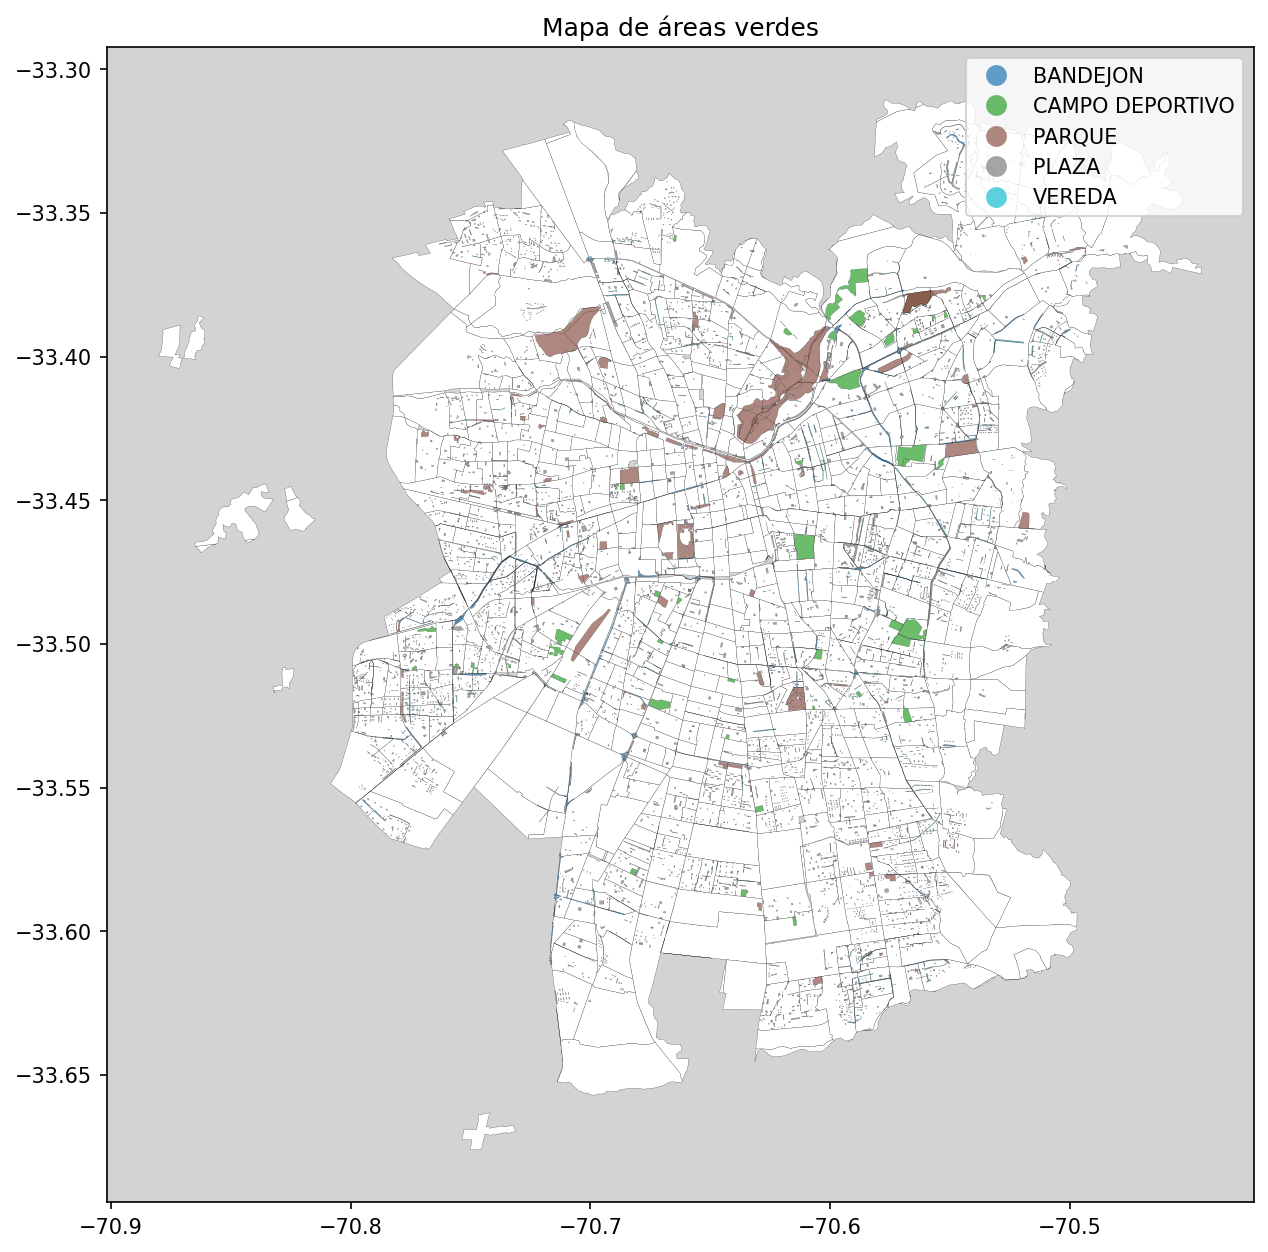

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
zones.plot(ax=ax, color="white", edgecolor="black", linewidth=0.1, alpha=1)
areas_verdes.plot(ax=ax, column="clase", legend=True, edgecolor="black", linewidth=0.1, alpha=0.7)
ax.set_title("Mapa de áreas verdes")
ax.set_facecolor("lightgray")

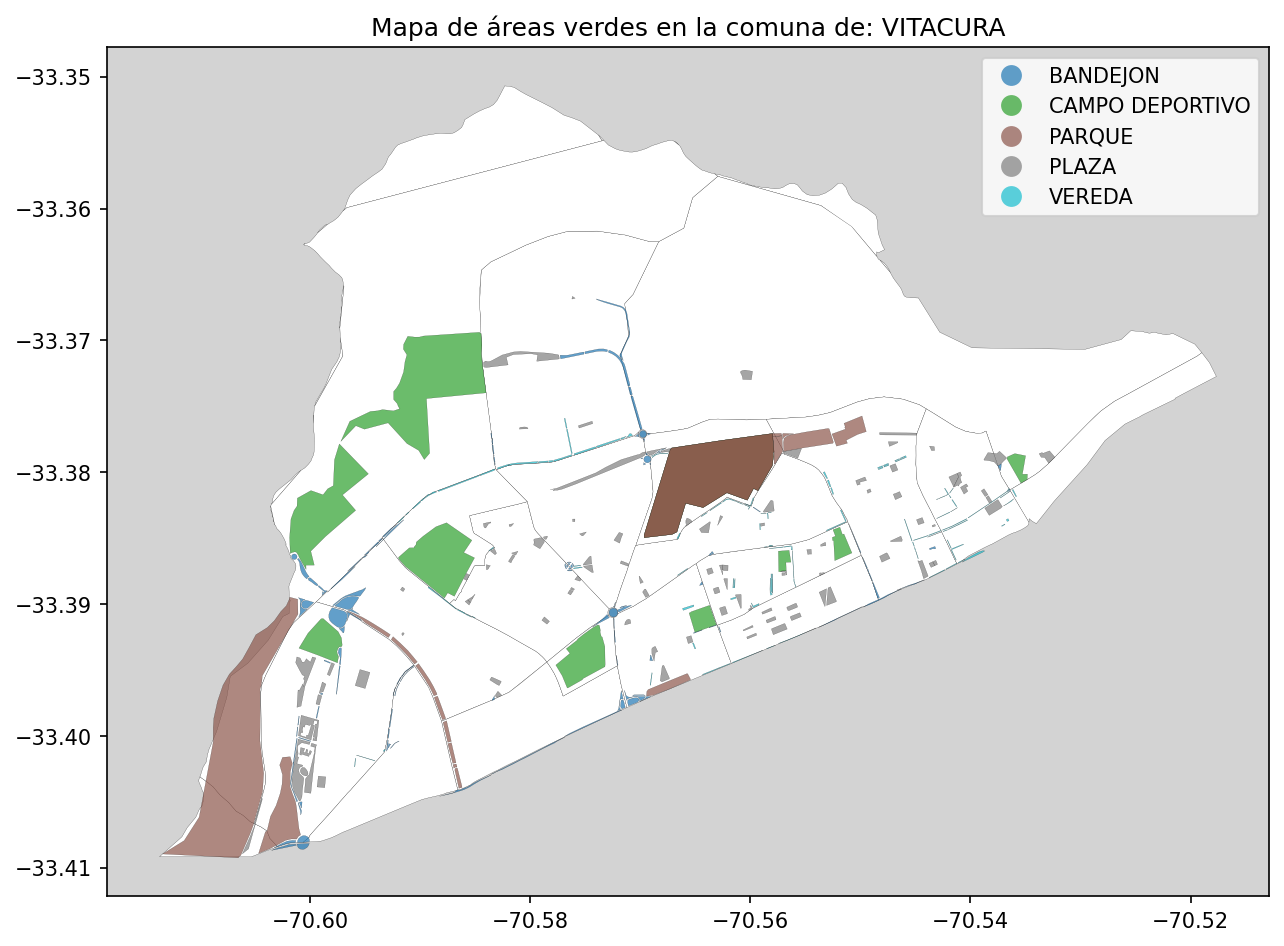

In [8]:
_comuna = "vitacura".upper()
_areas_verdes_comuna = areas_verdes[areas_verdes['Comuna'] == _comuna]
_zones_comuna = zones[zones['Comuna'] == _comuna]
fig, ax = plt.subplots(figsize=(10, 10))
_zones_comuna.plot(ax=ax, color="white", edgecolor="black", linewidth=0.1, alpha=1)
_areas_verdes_comuna.plot(ax=ax, column="clase", legend=True, edgecolor="black", linewidth=0.1, alpha=0.7)
ax.set_title(f"Mapa de áreas verdes en la comuna de: {_comuna}")
ax.set_facecolor("lightgray")

### ¿Cual es la superficie total de los tipos de areas verdes?

area_ha
clase                       
VEREDA            161.182139
PLAZA            1146.003313
PARQUE           1496.134607
CAMPO DEPORTIVO   625.728011
BANDEJON          396.092897

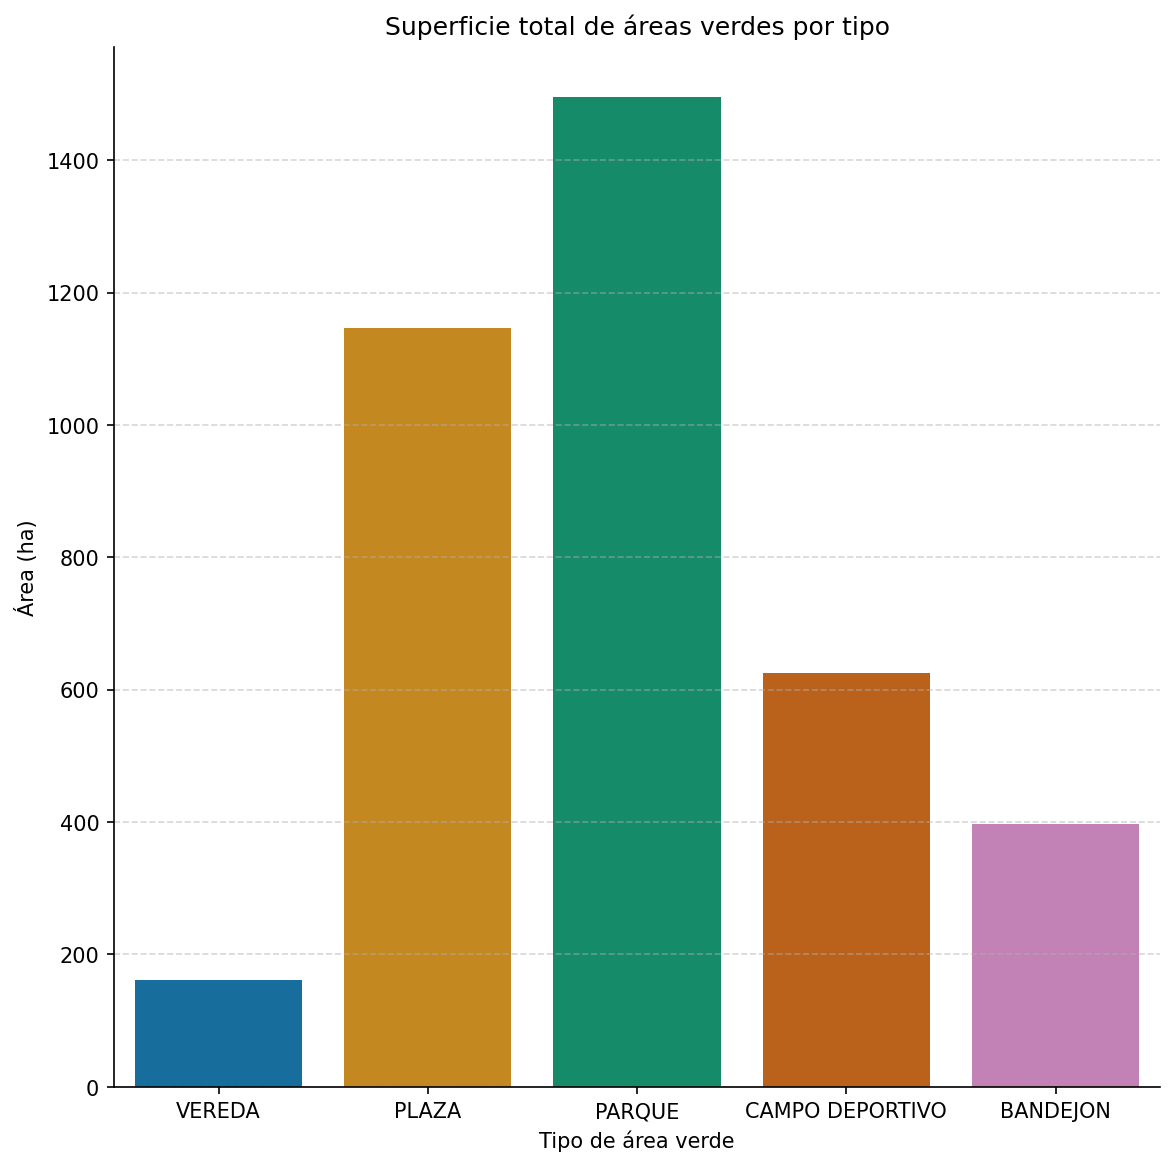

In [9]:
# superficie total por tipo de área verde
superficie_total_tipo = areas_verdes.groupby("clase").agg({"area_ha": "sum"}).sort_values("clase", ascending=False)

# plot
fig, ax = plt.subplots(figsize=(9, 9))
sns.barplot(
    data=superficie_total_tipo,
    x=superficie_total_tipo.index,
    y="area_ha",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Tipo de área verde")
ax.set_ylabel("Área (ha)")
ax.set_title("Superficie total de áreas verdes por tipo")
ax.grid(axis="y", linestyle="--", alpha=0.5)
sns.despine()

superficie_total_tipo


### ¿Y su promedio de superficie?

area_ha
clase                     
VEREDA            0.068067
PLAZA             0.177345
PARQUE            6.991283
CAMPO DEPORTIVO  12.769959
BANDEJON          0.157869

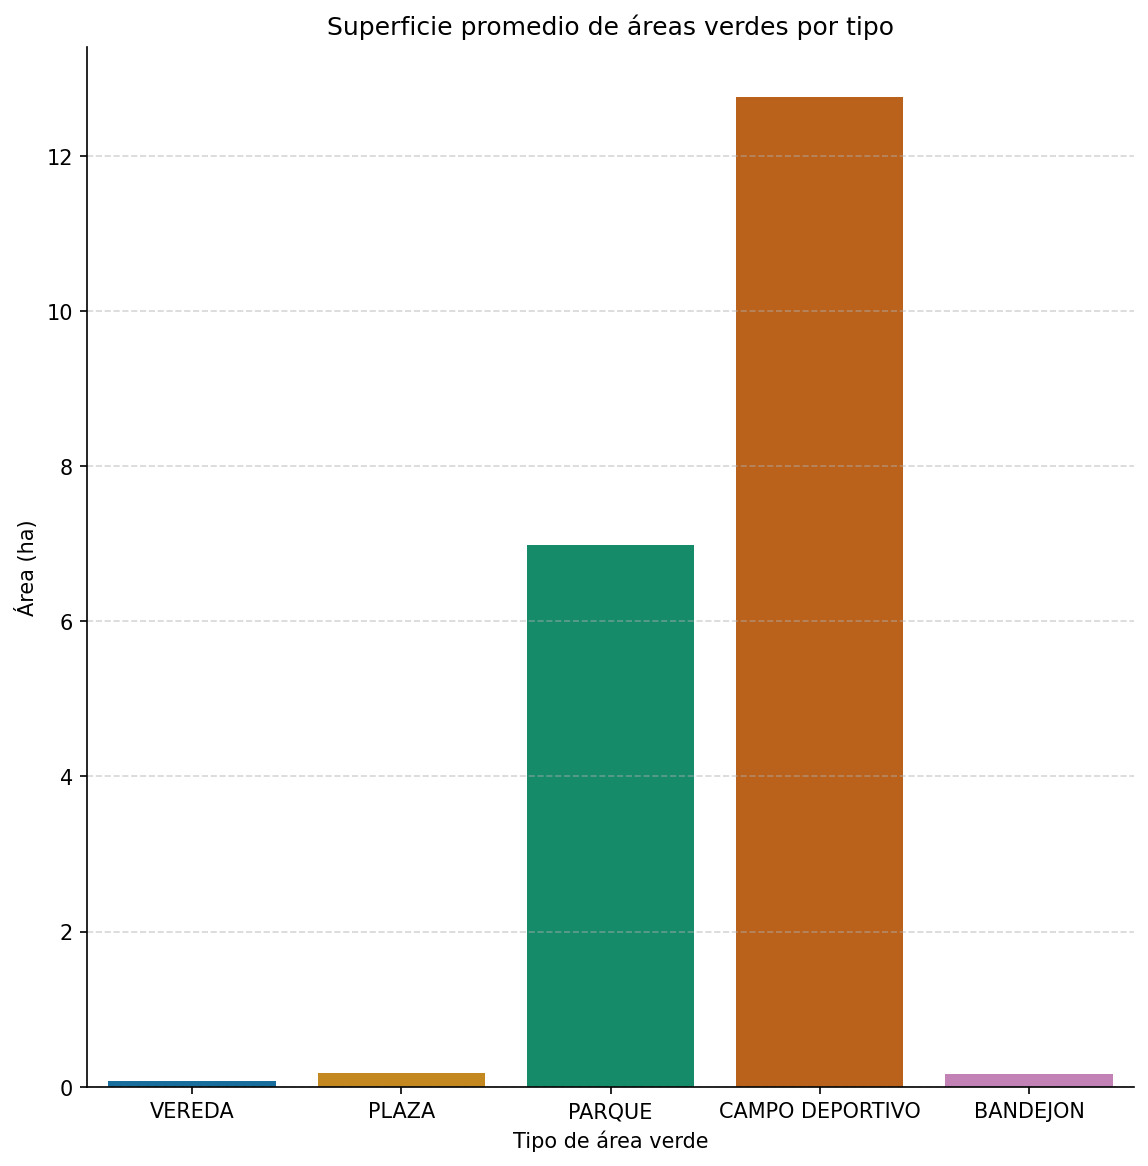

In [10]:
# promedio de superficie por tipo
superficie_promedio_tipo = areas_verdes.groupby("clase").agg({"area_ha": "mean"}).sort_values("clase", ascending=False)

# plot
fig, ax = plt.subplots(figsize=(9, 9))
sns.barplot(
    data=superficie_promedio_tipo,
    x=superficie_promedio_tipo.index,
    y="area_ha",
    ax=ax,
    palette="colorblind",
    dodge=False,
)
ax.set_xlabel("Tipo de área verde")
ax.set_ylabel("Área (ha)")
ax.set_title("Superficie promedio de áreas verdes por tipo")
ax.grid(axis="y", linestyle="--", alpha=0.5)
sns.despine()

superficie_promedio_tipo

A partir de los resultados de superficie total y promedio, solo consideraremos Parques, plazas y campos deportivos

## Superficie y cantidad de areas verdes por comuna

Comuna            clase     area_ha  n_areas
0     CERRILLOS  CAMPO DEPORTIVO   43.704610        5
1     CERRILLOS           PARQUE   56.665791        2
2     CERRILLOS            PLAZA   25.734503       87
3   CERRO NAVIA           PARQUE   15.749139       13
4   CERRO NAVIA            PLAZA   12.833342       88
..          ...              ...         ...      ...
78     VITACURA           PARQUE  213.496400       18
79     VITACURA            PLAZA   39.371505      102
80        ÑUÑOA  CAMPO DEPORTIVO   63.600374        1
81        ÑUÑOA           PARQUE    5.044460        5
82        ÑUÑOA            PLAZA   53.658268      190

[83 rows x 4 columns]

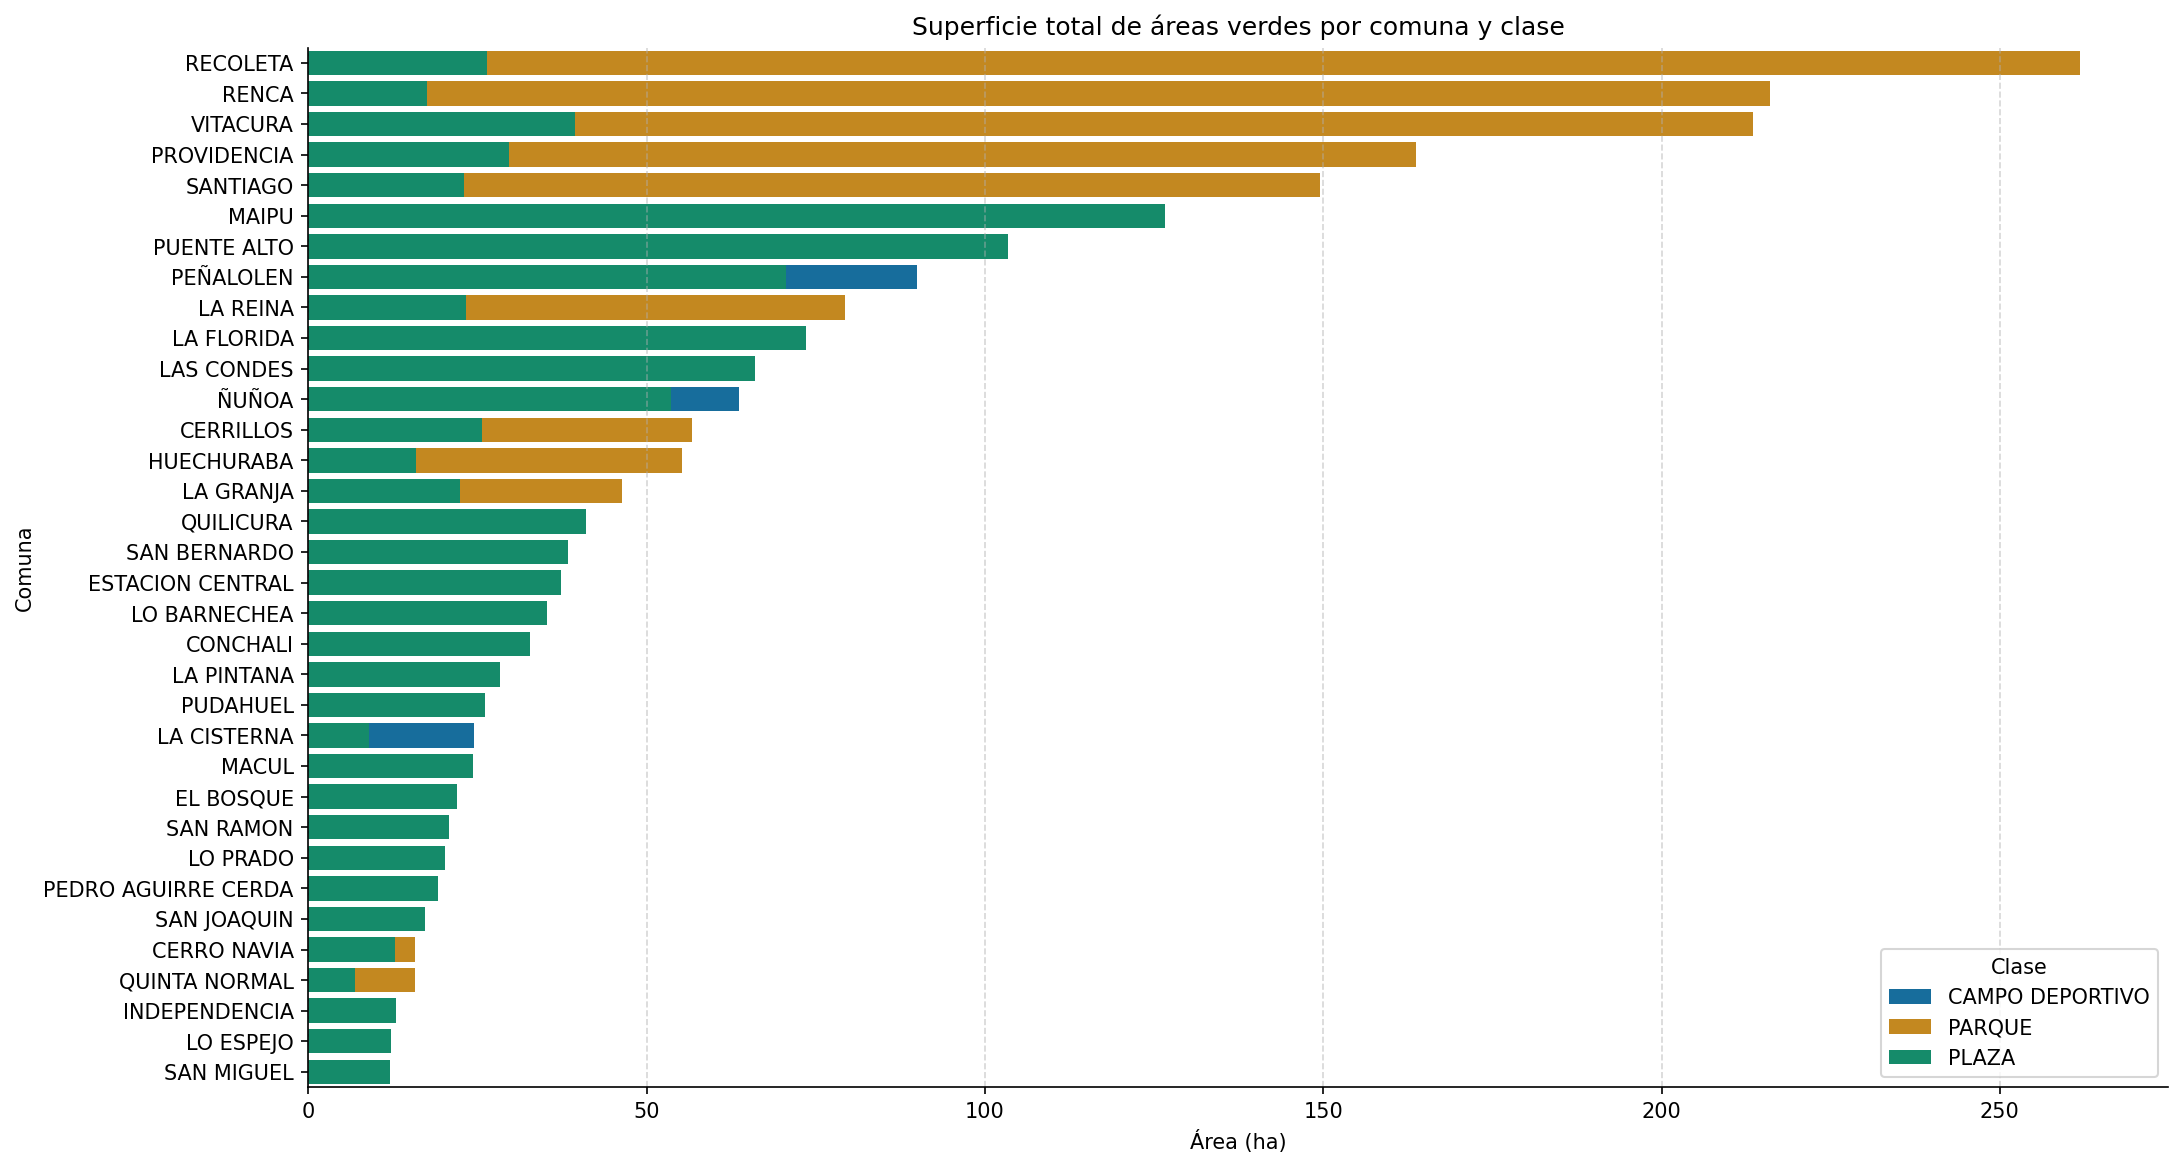

In [11]:
filtro = ['PARQUE', 'PLAZA', 'CAMPO DEPORTIVO']

superficie_comuna_clase = areas_verdes[
    areas_verdes["clase"].isin(filtro)
    ].groupby(["Comuna", "clase"]).agg({"area_ha": "sum", "Comuna": "count"}).rename(columns={"Comuna": "n_areas"}).reset_index()

# plot
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(
    data=superficie_comuna_clase,
    x="area_ha",
    y="Comuna",
    hue="clase",
    ax=ax,
    palette="colorblind",
    dodge=False,
    order=superficie_comuna_clase.sort_values("area_ha", ascending=False)["Comuna"].unique()
)
ax.set_xlabel("Área (ha)")
ax.set_ylabel("Comuna")
ax.set_title("Superficie total de áreas verdes por comuna y clase")
ax.legend(title="Clase", loc="lower right")
ax.grid(axis="x", linestyle="--", alpha=0.5)
sns.despine()

superficie_comuna_clase

### ¿Cantidad de Areas verdes se relaciona con la poblacion?
agregar grafico con areas verdes por cada 1000 habitantes

Comuna            clase  n_areas     area_ha    population   
0     CERRILLOS  CAMPO DEPORTIVO        5   43.704610   78575.22841  \
1     CERRILLOS           PARQUE        2   56.665791   78575.22841   
2     CERRILLOS            PLAZA       87   25.734503   78575.22841   
3   CERRO NAVIA           PARQUE       13   15.749139  137761.35020   
4   CERRO NAVIA            PLAZA       88   12.833342  137761.35020   
..          ...              ...      ...         ...           ...   
78     VITACURA           PARQUE       18  213.496400   96187.95887   
79     VITACURA            PLAZA      102   39.371505   96187.95887   
80        ÑUÑOA  CAMPO DEPORTIVO        1   63.600374  211265.10313   
81        ÑUÑOA           PARQUE        5    5.044460  211265.10313   
82        ÑUÑOA            PLAZA      190   53.658268  211265.10313   

    area_ha_por_1000_habitantes  
0                      0.556214  
1                      0.721166  
2                      0.327514  
3                      0.114322  
4                      0.093156  
..                          ...  
78                     2.219575  
79                     0.409318  
80                     0.301045  
81                     0.023877  
82                     0.253985  

[83 rows x 6 columns]

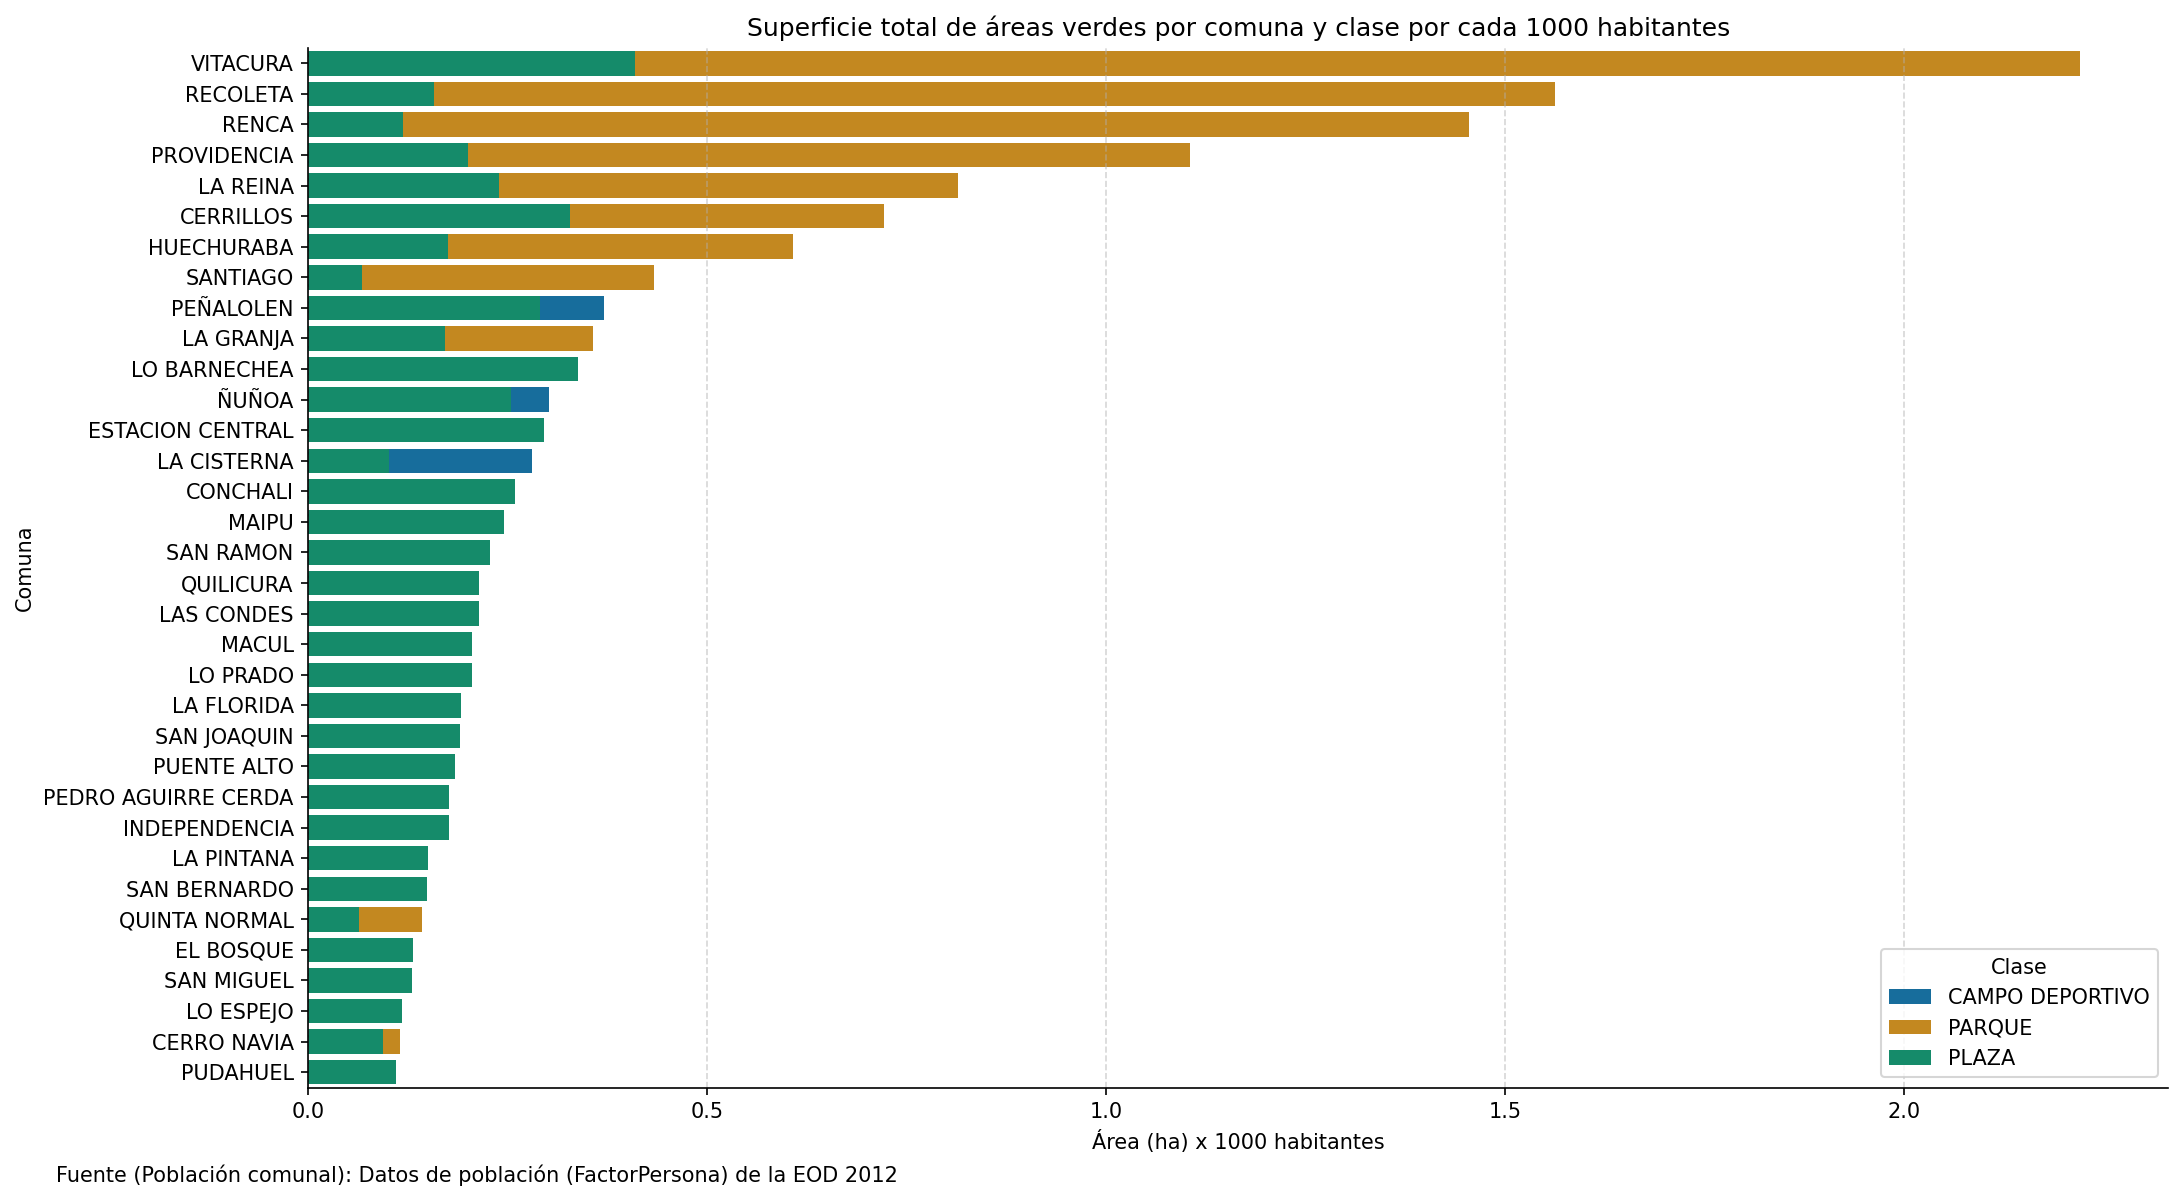

In [12]:
# obtenemos la población de cada comuna
persona_hogar = eod_personas.merge(eod_hogares)
poblacion_por_comuna = persona_hogar.groupby('Comuna')['FactorPersona'].sum().rename('population')

# obtenemos areas verdes por comuna y clase
area_comuna_clase = areas_verdes[
    areas_verdes["clase"].isin(filtro)
].groupby(["Comuna", "clase"]).agg({"Comuna": "count", "area_ha": "sum"}).rename(columns={"Comuna": "n_areas"}).reset_index()

# obtenemos hectareas de areas verdes por 1000 habitantes
area_comuna_clase_por_1000_habitantes = area_comuna_clase.merge(poblacion_por_comuna, on='Comuna')
area_comuna_clase_por_1000_habitantes['area_ha_por_1000_habitantes'] = area_comuna_clase_por_1000_habitantes['area_ha'] / area_comuna_clase_por_1000_habitantes['population'] * 1000

# plot
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(
    data=area_comuna_clase_por_1000_habitantes,
    x="area_ha_por_1000_habitantes",
    y="Comuna",
    hue="clase",
    ax=ax,
    palette="colorblind",
    dodge=False,
    order=area_comuna_clase_por_1000_habitantes.sort_values("area_ha_por_1000_habitantes", ascending=False)["Comuna"].unique()
)
ax.set_xlabel("Área (ha) x 1000 habitantes")
ax.set_ylabel("Comuna")
ax.set_title("Superficie total de áreas verdes por comuna y clase por cada 1000 habitantes")
ax.legend(title="Clase", loc="lower right")
ax.grid(axis="x", linestyle="--", alpha=0.5)
fig.text(0.02, 0.04, 'Fuente (Población comunal): Datos de población (FactorPersona) de la EOD 2012')
sns.despine()

area_comuna_clase_por_1000_habitantes

### ¿Cuanta gente vive cerca de cada area verde?


In [13]:
# consideramos solo parques, plazas y campos deportivos para este análisis
filtro = ['PARQUE', 'PLAZA', 'CAMPO DEPORTIVO']


### ¿Cuanta gente trabaja cerca de cada area verde?

In [14]:
viajes_por_trabajo = eod_viajes[eod_viajes['Proposito'] == 'Al trabajo'].groupby('ZonaDestino')['FactorLaboralNormal'].sum().rename('viajes_por_trabajo').sort_values(ascending=False).reset_index()
viajes_por_trabajo


ZonaDestino  viajes_por_trabajo
0             20          457.318133
1            287          309.683979
2             18          288.892191
3            498          244.955058
4            307          162.280617
..           ...                 ...
725          693            0.000000
726          615            0.000000
727          670            0.000000
728          664            0.000000
729          102            0.000000

[730 rows x 2 columns]

### ¿Flujo de personas cerca de cada areas verde?


### ¿Hay correlacion entre tasa de areas verdes por habitante e ingreso comunal promedio?

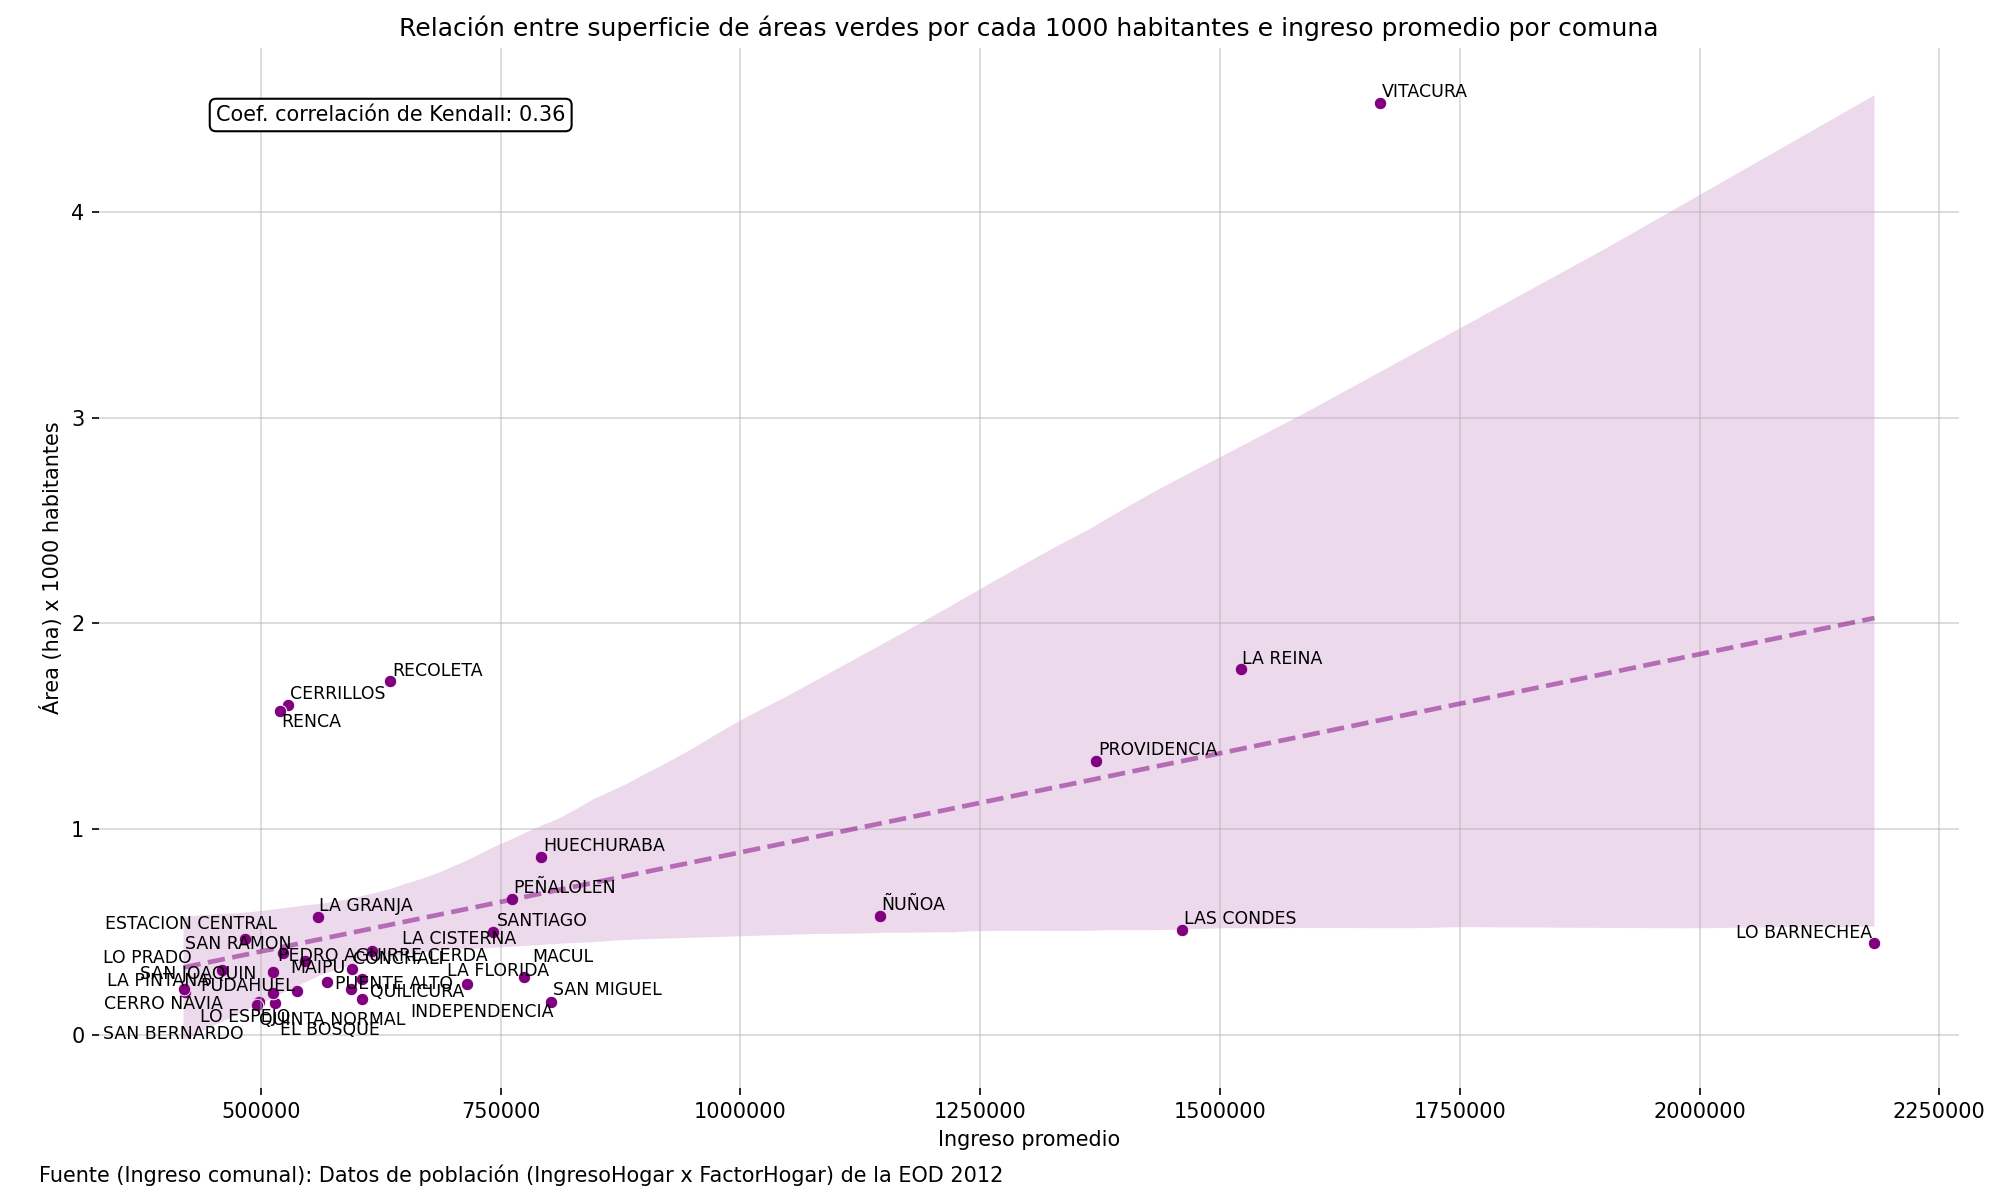

In [15]:
from aves.features.utils import weighted_mean
from aves.visualization.tables import scatterplot

# obtenemos ingreso promedio por comuna
ingreso_comunal_promedio = eod_hogares.groupby('Comuna').apply(lambda x: weighted_mean(x, 'IngresoHogar', 'FactorHogar')).rename('ingreso promedio')

# obtenemos la población de cada comuna
persona_hogar = eod_personas.merge(eod_hogares)
poblacion_por_comuna = persona_hogar.groupby('Comuna')['FactorPersona'].sum().rename('population')

# obtenemos areas verdes por comuna
area_comuna = areas_verdes[
    areas_verdes["clase"].isin(filtro)
].groupby("Comuna").agg({"Comuna": "count", "area_ha": "sum"}).rename(columns={"Comuna": "n_areas"}).reset_index()

# obtenemos hectareas de areas verdes por 1000 habitantes
area_comuna_por_1000_habitantes = area_comuna.merge(poblacion_por_comuna, on='Comuna')
area_comuna_por_1000_habitantes['area_ha_por_1000_habitantes'] = area_comuna_por_1000_habitantes['area_ha'] / area_comuna_por_1000_habitantes['population'] * 1000

df = area_comuna_por_1000_habitantes.merge(ingreso_comunal_promedio, on='Comuna')[['Comuna', 'area_ha_por_1000_habitantes', 'ingreso promedio']]
df.index = df['Comuna']
df = df.drop('Comuna', axis=1)

#plot
fig, ax = plt.subplots(figsize=(16, 9))
scatterplot(
    ax=ax,
    df=df,
    x="ingreso promedio",
    y="area_ha_por_1000_habitantes",
    annotate=True,
    avoid_collisions=True,
    text_args=dict(fontsize="small"),
    scatter_args=dict(color="purple"),
)
# agregar linea de tendencia
sns.regplot(
    data=df,
    x="ingreso promedio",
    y="area_ha_por_1000_habitantes",
    ax=ax,
    scatter=False,
    color="purple",
    line_kws=dict(linestyle="--", alpha=0.5),
)

ax.set_xlabel("Ingreso promedio")
ax.set_ylabel("Área (ha) x 1000 habitantes")
ax.set_title("Relación entre superficie de áreas verdes por cada 1000 habitantes e ingreso promedio por comuna")
ax.grid(alpha=0.5)
ax.annotate(
    f"Coef. correlación de Kendall: {df.corr(method='kendall').iloc[0, 1]:.2f}",
    xy=(0.09, 0.8),
    xycoords="figure fraction",
    fontsize="medium",
    color="black",
    bbox=dict(boxstyle="round", fc="white", ec="black", alpha=1),
)
ax.ticklabel_format(style="plain")
fig.text(0.1, 0.04, f'Fuente (Ingreso comunal): Datos de población (IngresoHogar x FactorHogar) de la EOD 2012')

sns.despine(ax=ax, left=True, bottom=True, right=True, top=True)

### ¿Cual es la distribucion de distancia o tiempo de viaje a areas verdes en distintos sectores de la ciudad?

### ¿Cual es el porcentaje de area verde con respecto al area total de la comuna?

### ¿Como se distribuye la superficie de areas verdes?

In [16]:
# pasar areas verdes a punto (centroide)

# change crs to a projected one to
areas_verdes_centroids = areas_verdes[
    areas_verdes["clase"].isin(filtro)
].to_crs(epsg=32719)
areas_verdes_centroids['geometry'] = areas_verdes_centroids['geometry'].centroid
# restore crs
areas_verdes_centroids = areas_verdes_centroids.to_crs(epsg=4326)
areas_verdes_centroids = areas_verdes_centroids[["FID", "Comuna", "estado", "area_ha", "estado_2", "layer", "clase", "geometry"]].set_index("FID")
areas_verdes_centroids["normalized_area"] = areas_verdes_centroids["area_ha"] / areas_verdes_centroids["area_ha"].sum()
areas_verdes_centroids

Comuna             estado   area_ha estado_2 layer  clase   
FID                                                                     
1      PUENTE ALTO  DESAFECTADA VERDE  0.024171     BUEN  BUEN  PLAZA  \
2      PUENTE ALTO  DESAFECTADA VERDE  0.017404     BUEN  BUEN  PLAZA   
3      PUENTE ALTO  DESAFECTADA VERDE  0.015832     BUEN  BUEN  PLAZA   
7      PUENTE ALTO  DESAFECTADA VERDE  0.020344     BUEN  BUEN  PLAZA   
8      PUENTE ALTO  DESAFECTADA VERDE  0.015389     BUEN  BUEN  PLAZA   
...            ...                ...       ...      ...   ...    ...   
11590   LAS CONDES  DESAFECTADA VERDE  0.070079     BUEN  BUEN  PLAZA   
11591   LAS CONDES  DESAFECTADA VERDE  0.052885     BUEN  BUEN  PLAZA   
11597   LAS CONDES  DESAFECTADA VERDE  0.041501     BUEN  BUEN  PLAZA   
11601   LAS CONDES  DESAFECTADA VERDE  0.039240     BUEN  BUEN  PLAZA   
11602   LAS CONDES  DESAFECTADA VERDE  0.035163     BUEN  BUEN  PLAZA   

                          geometry  normalized_area  
FID                                                  
1      POINT (-70.58391 -33.56618)         0.000007  
2      POINT (-70.56742 -33.56876)         0.000005  
3      POINT (-70.56737 -33.56903)         0.000005  
7      POINT (-70.60237 -33.57602)         0.000006  
8      POINT (-70.60348 -33.57508)         0.000005  
...                            ...              ...  
11590  POINT (-70.54944 -33.39080)         0.000021  
11591  POINT (-70.54911 -33.39144)         0.000016  
11597  POINT (-70.53549 -33.38863)         0.000013  
11601  POINT (-70.53457 -33.38931)         0.000012  
11602  POINT (-70.53430 -33.38915)         0.000011  

[6725 rows x 8 columns]

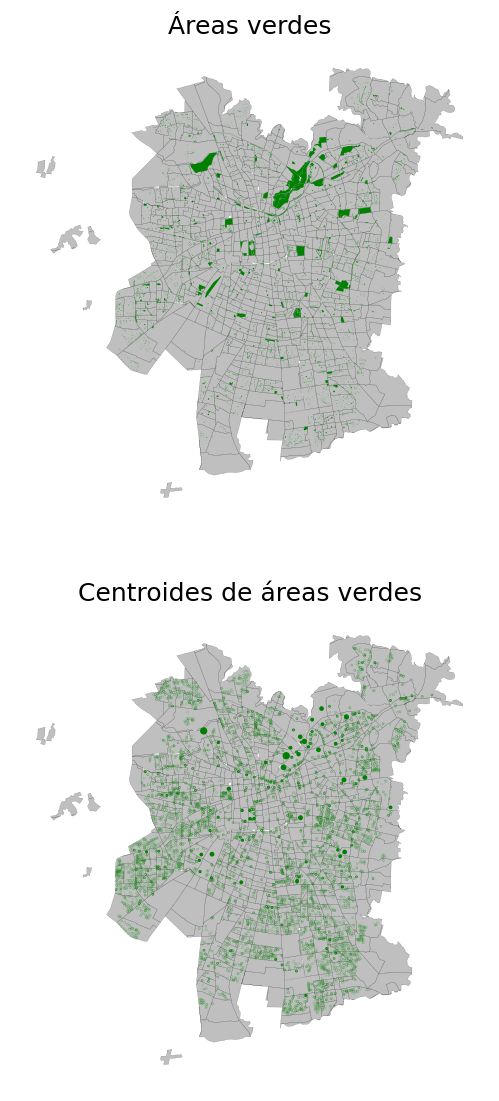

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(5, 9))
zones.plot(ax=ax[0], color='grey', edgecolor="black", linewidth=0.1, alpha=0.5)
zones.plot(ax=ax[1], color='grey', edgecolor="black", linewidth=0.1, alpha=0.5)

areas_verdes[
    areas_verdes["clase"].isin(filtro)
].plot(ax=ax[0], color="green")
areas_verdes_centroids.plot(
    ax=ax[1], 
    color="green",
    markersize=areas_verdes_centroids["normalized_area"] * 100,
)

ax[0].set_title("Áreas verdes")
ax[1].set_title("Centroides de áreas verdes")
ax[0].set_axis_off()
ax[1].set_axis_off()

In [18]:
zones[['Zona', 'geometry']]

Zona                                           geometry
ID                                                           
103  103.0  POLYGON ((-70.65492 -33.55500, -70.65517 -33.5...
104  104.0  POLYGON ((-70.67599 -33.55542, -70.67452 -33.5...
106  106.0  POLYGON ((-70.69714 -33.56361, -70.69714 -33.5...
115  115.0  POLYGON ((-70.67625 -33.55513, -70.67653 -33.5...
116  116.0  POLYGON ((-70.66564 -33.55260, -70.66309 -33.5...
..     ...                                                ...
375  375.0  POLYGON ((-70.60683 -33.49552, -70.60602 -33.4...
366  366.0  POLYGON ((-70.61344 -33.47446, -70.60990 -33.4...
364  364.0  POLYGON ((-70.59655 -33.47354, -70.59497 -33.4...
369  369.0  POLYGON ((-70.59590 -33.48557, -70.59681 -33.4...
365  365.0  POLYGON ((-70.60427 -33.47400, -70.60126 -33.4...

[781 rows x 2 columns]

In [19]:
zones_areas_verdes = gpd.sjoin(zones[['geometry']], areas_verdes_centroids, how='left', op='intersects')
zones_areas_verdes = zones_areas_verdes[['Comuna', 'estado', 'area_ha', 'estado_2', 'clase', 'geometry']]
zones_areas_verdes

Comuna             estado   area_ha estado_2  clase   
ID                                                            
103  EL BOSQUE        CONSOLIDADA  0.176014     BUEN  PLAZA  \
103  EL BOSQUE  DESAFECTADA VERDE  0.164441      MAL  PLAZA   
103  EL BOSQUE  DESAFECTADA VERDE  0.206301     BUEN  PLAZA   
103  EL BOSQUE  DESAFECTADA VERDE  0.189858      MAL  PLAZA   
103  EL BOSQUE        CONSOLIDADA  0.139270     BUEN  PLAZA   
..         ...                ...       ...      ...    ...   
364      MACUL  DESAFECTADA VERDE  0.140295     BUEN  PLAZA   
369      MACUL        CONSOLIDADA  0.400105     BUEN  PLAZA   
365      MACUL        DETERIORADA  0.311948      MAL  PLAZA   
365      MACUL  DESAFECTADA VERDE  0.072923     BUEN  PLAZA   
365      MACUL  DESAFECTADA VERDE  0.064727     BUEN  PLAZA   

                                              geometry  
ID                                                      
103  POLYGON ((-70.65492 -33.55500, -70.65517 -33.5...  
103  POLYGON ((-70.65492 -33.55500, -70.65517 -33.5...  
103  POLYGON ((-70.65492 -33.55500, -70.65517 -33.5...  
103  POLYGON ((-70.65492 -33.55500, -70.65517 -33.5...  
103  POLYGON ((-70.65492 -33.55500, -70.65517 -33.5...  
..                                                 ...  
364  POLYGON ((-70.59655 -33.47354, -70.59497 -33.4...  
369  POLYGON ((-70.59590 -33.48557, -70.59681 -33.4...  
365  POLYGON ((-70.60427 -33.47400, -70.60126 -33.4...  
365  POLYGON ((-70.60427 -33.47400, -70.60126 -33.4...  
365  POLYGON ((-70.60427 -33.47400, -70.60126 -33.4...  

[6840 rows x 6 columns]

In [20]:
zone_disolved_areas_verdes = zones_areas_verdes.dissolve(
    by='ID',
    aggfunc={'area_ha': 'sum'}
)
zone_disolved_areas_verdes

geometry   area_ha
ID                                                              
1    POLYGON ((-70.67232 -33.43232, -70.67405 -33.4...  0.000000
2    POLYGON ((-70.68029 -33.43585, -70.68055 -33.4...  0.000000
3    POLYGON ((-70.66871 -33.43766, -70.67178 -33.4...  0.616070
4    POLYGON ((-70.67979 -33.44158, -70.68009 -33.4...  0.000000
5    POLYGON ((-70.67406 -33.44216, -70.67418 -33.4...  0.000000
..                                                 ...       ...
778  POLYGON ((-70.74279 -33.54334, -70.74266 -33.5...  0.000000
779  POLYGON ((-70.71159 -33.56720, -70.71165 -33.5...  2.334294
780  POLYGON ((-70.71265 -33.57396, -70.71254 -33.5...  0.543801
781  POLYGON ((-70.66159 -33.65195, -70.66160 -33.6...  0.094703
782  POLYGON ((-70.74342 -33.66817, -70.74339 -33.6...  0.000000

[752 rows x 2 columns]

Text(0.5, 0.05, 'Nota: Este mapa considera el centroide de cada área verde')

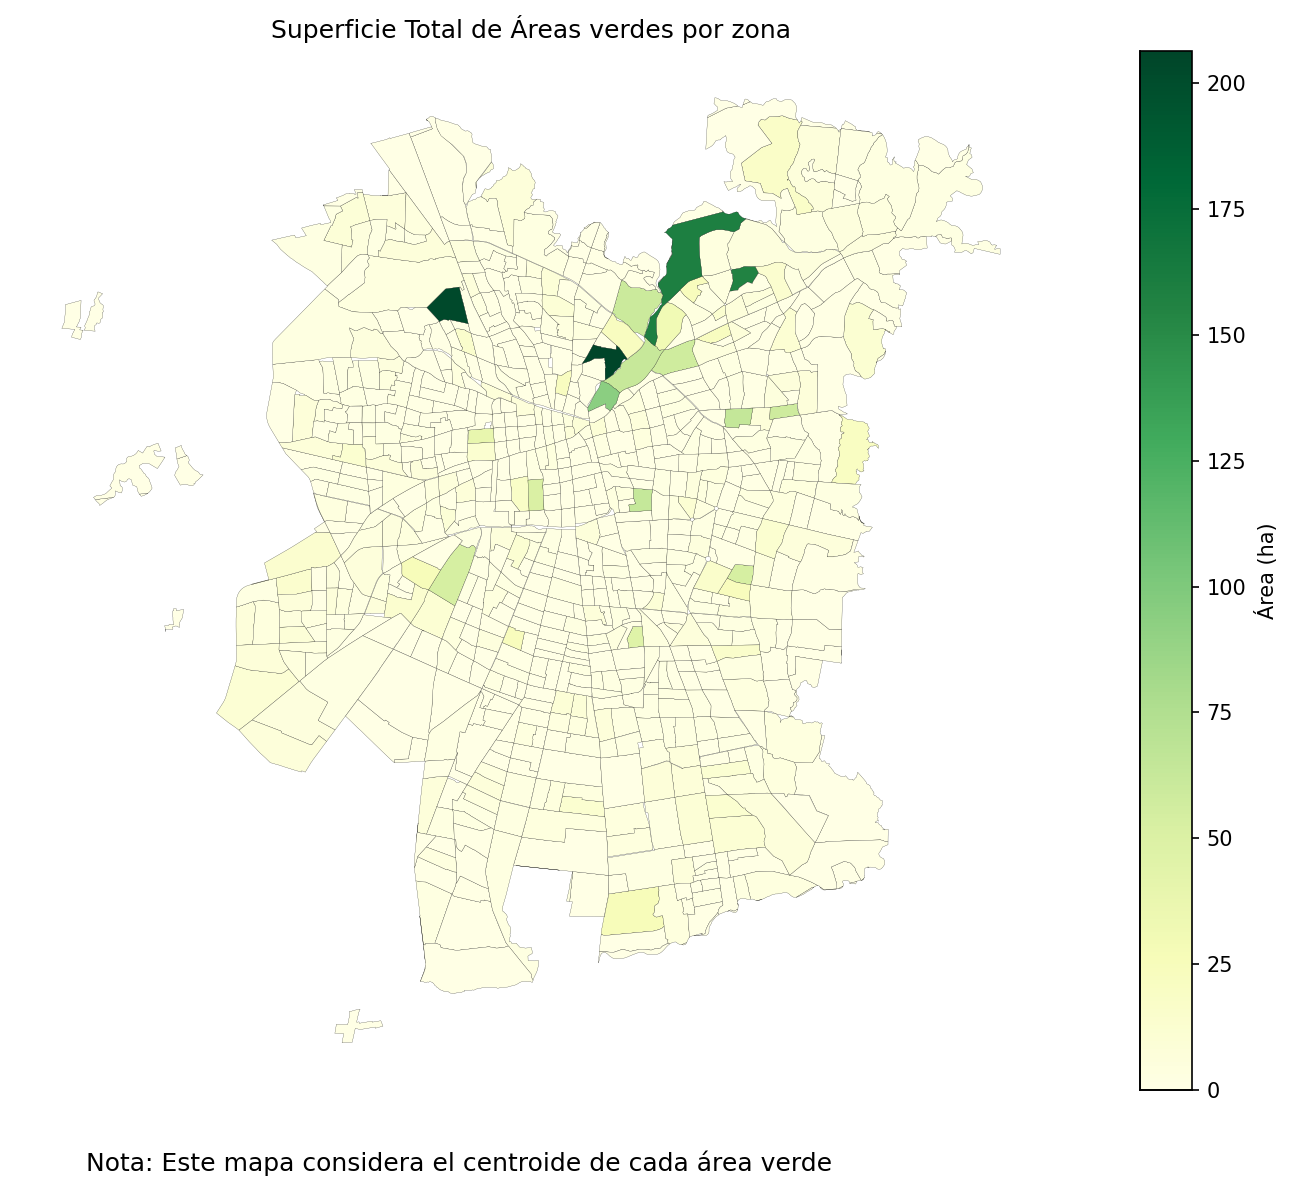

In [21]:
fig, ax = plt.subplots(figsize=(16, 9))
zone_disolved_areas_verdes.plot(ax=ax, column='area_ha', cmap='YlGn', legend=True, legend_kwds={'label': "Área (ha)"}, edgecolor='black', linewidth=0.1)
ax.set_title("Superficie Total de Áreas verdes por zona")
ax.set_facecolor('lightgrey')
ax.set_axis_off()
sns.despine()
fig.text(0.5, 0.05, "Nota: Este mapa considera el centroide de cada área verde", ha='center', fontsize=12)

Text(0.5, 0.05, 'Nota: Este mapa considera el centroide de cada área verde')

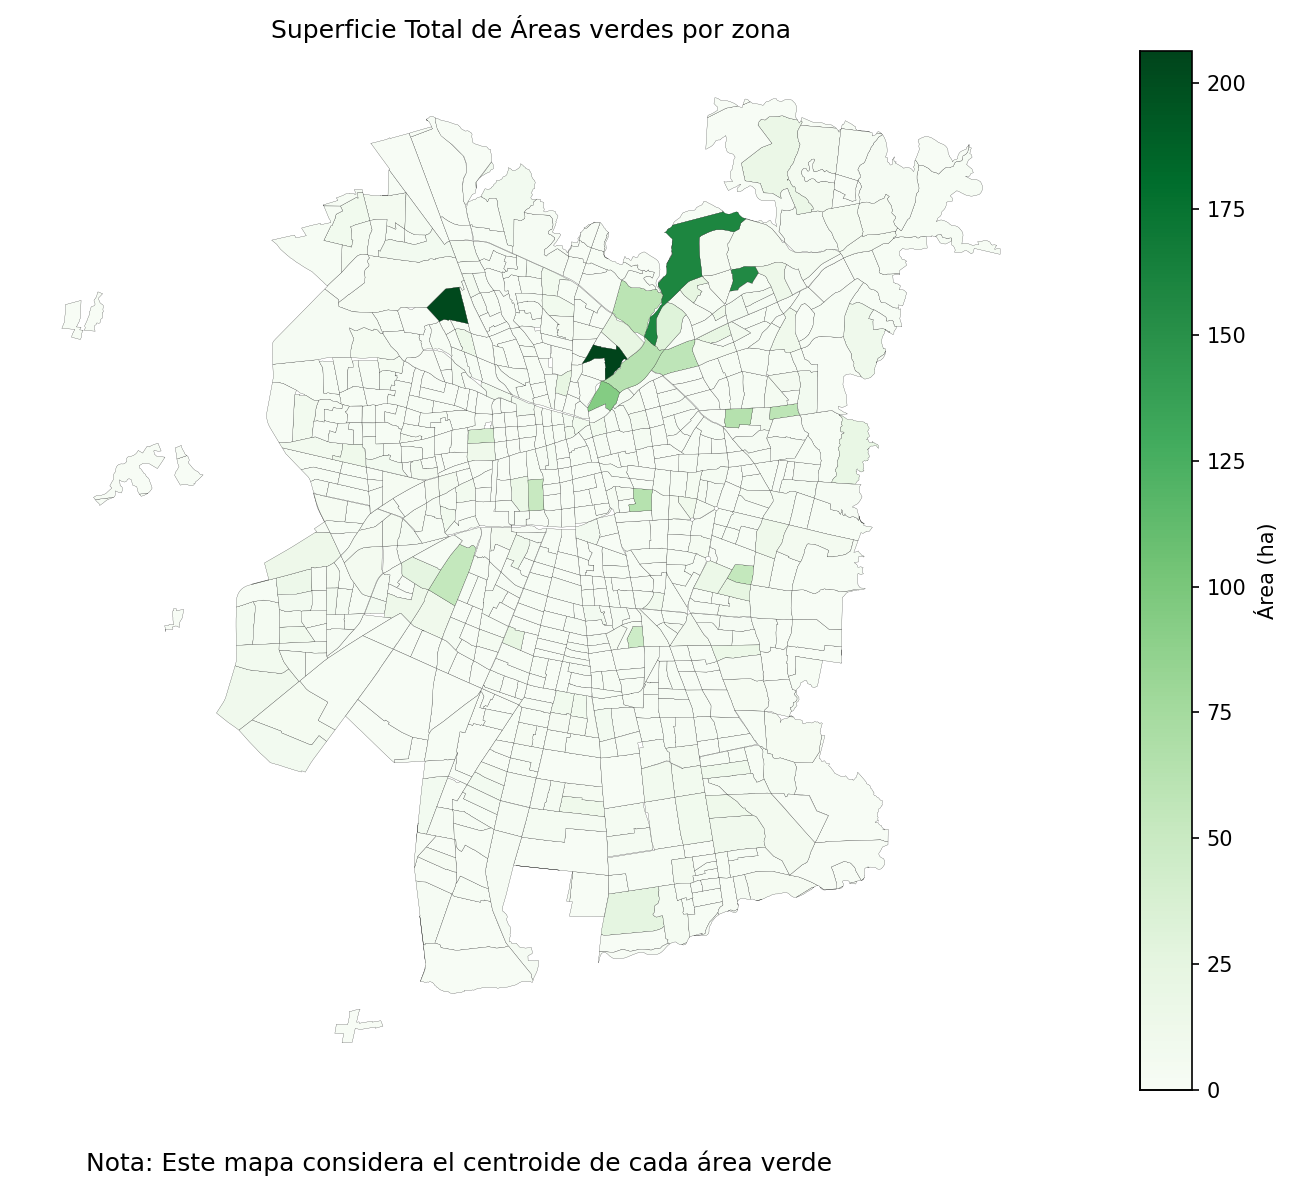

In [22]:
fig, ax = plt.subplots(figsize=(16, 9))
zone_disolved_areas_verdes.plot(ax=ax, column='area_ha', cmap='Greens', legend=True, legend_kwds={'label': "Área (ha)"}, edgecolor='black', linewidth=0.1)
ax.set_title("Superficie Total de Áreas verdes por zona")
ax.set_facecolor('lightgrey')
ax.set_axis_off()
sns.despine()
fig.text(0.5, 0.05, "Nota: Este mapa considera el centroide de cada área verde", ha='center', fontsize=12)

### ¿Y como se ve con respecto a los destinos y hogares?

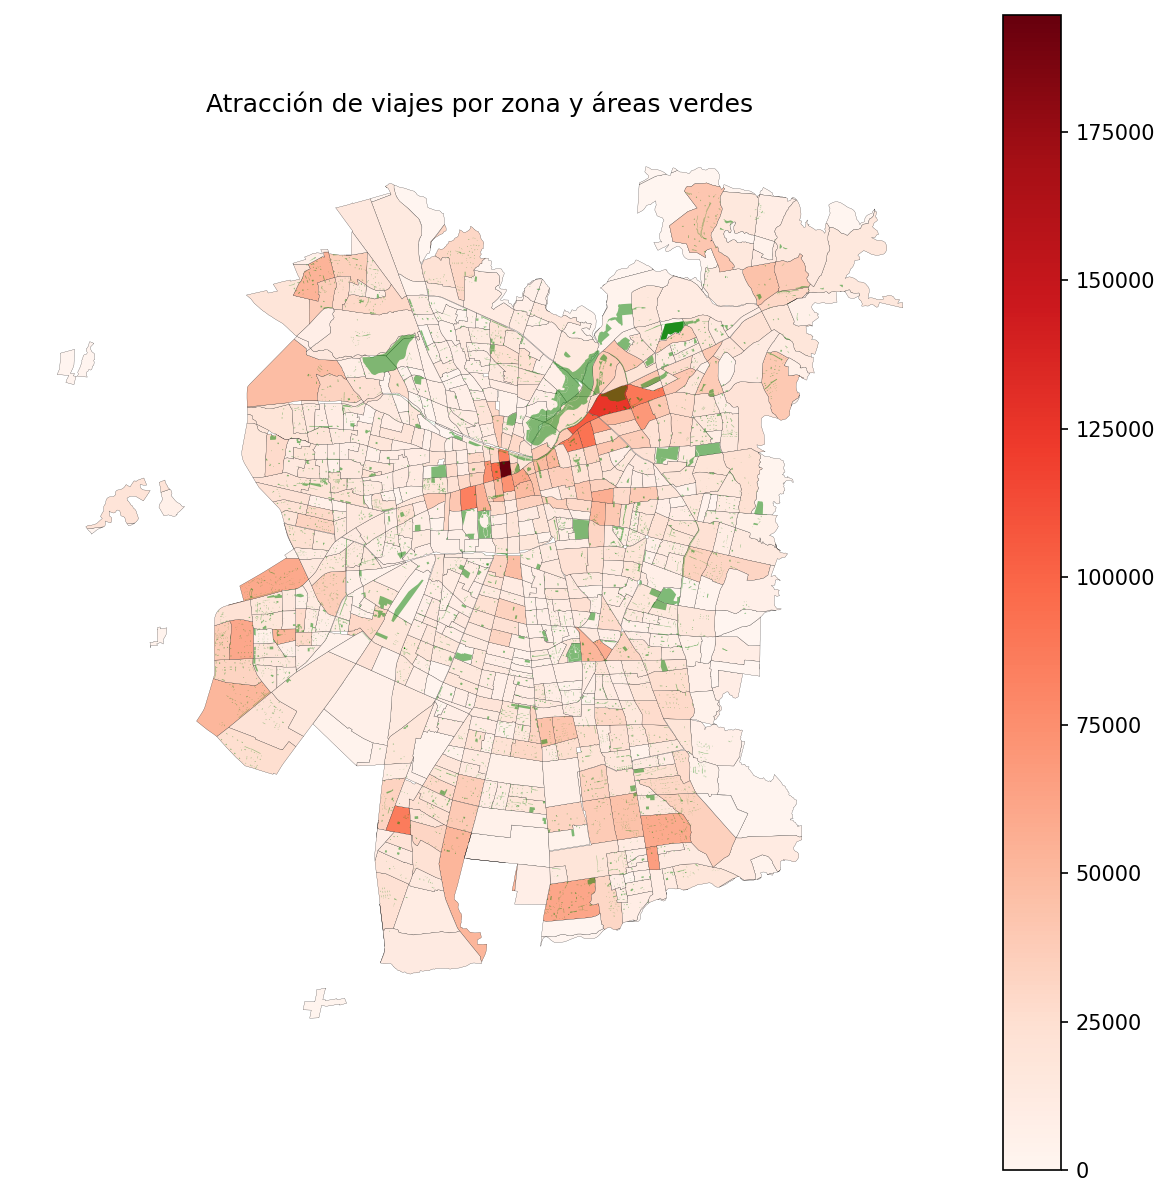

In [23]:
viajes_persona = eod_viajes.merge(eod_personas)

viajes_persona["PesoLaboral"] = (
    viajes_persona["FactorLaboralNormal"] * viajes_persona["Factor_LaboralNormal"]
)

viajes_persona = viajes_persona[pd.notnull(viajes_persona["PesoLaboral"])]
# destinos
expanded_destinos_zonas = viajes_persona.groupby(['ZonaDestino'])['PesoLaboral'].sum().rename('atraccion').to_frame()
expanded_destinos_zonas = zones.join(expanded_destinos_zonas, how='left', on='ID').fillna(0)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
expanded_destinos_zonas.plot(column="atraccion", legend=True, ax=ax, cmap="Reds", edgecolor="black", linewidth=0.1)
areas_verdes[areas_verdes["clase"].isin(filtro)].plot(
    color="green", ax=ax, alpha=0.5
)
ax.set_title("Atracción de viajes por zona y áreas verdes")
ax.set_axis_off()

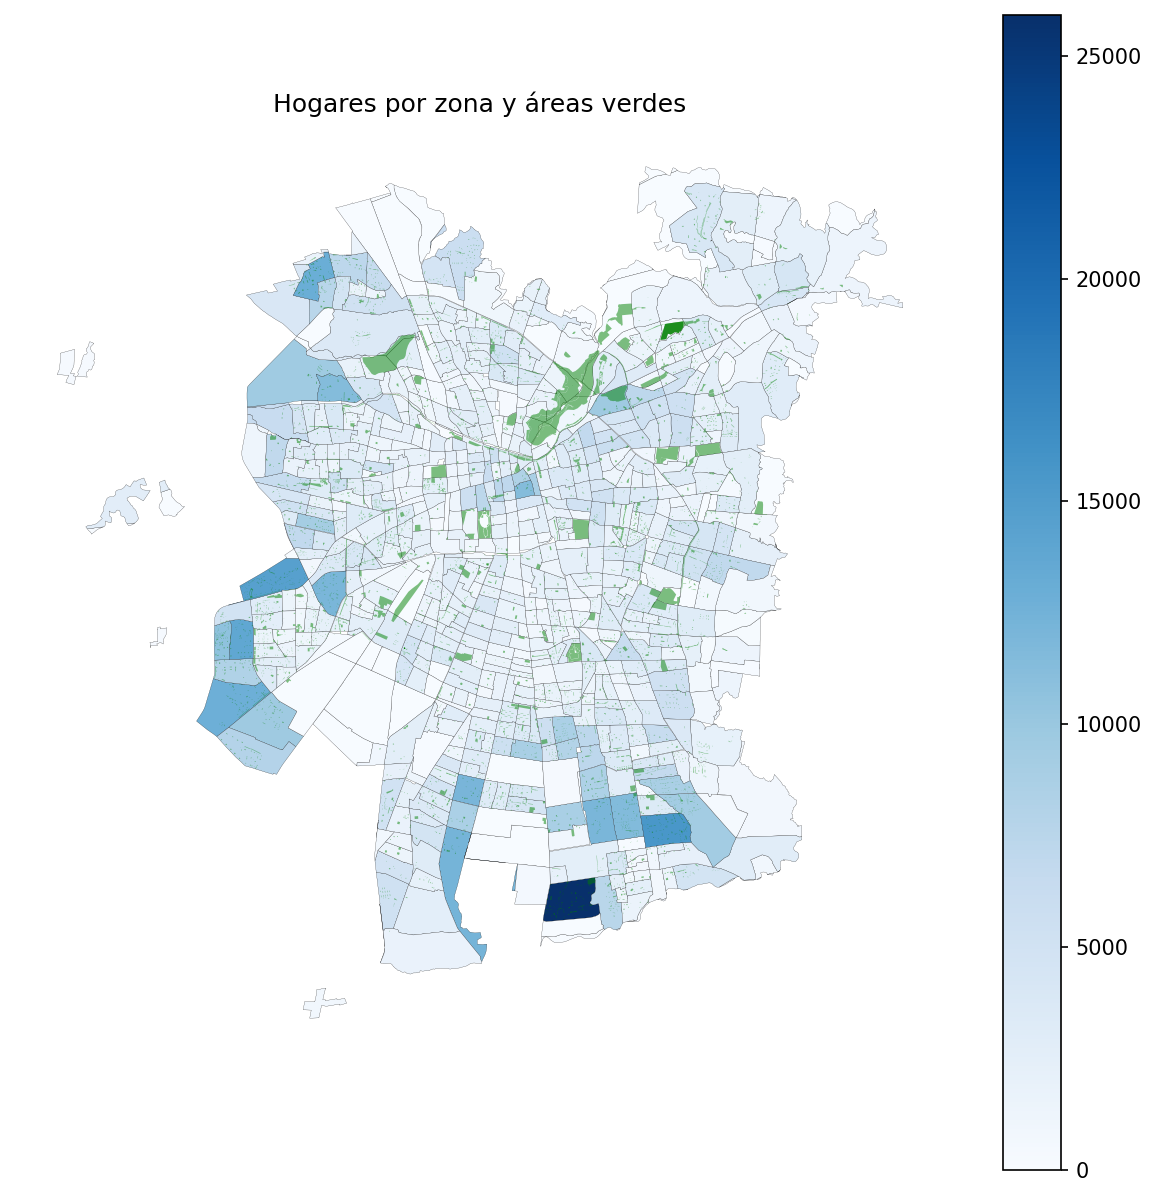

In [24]:
# hogares
expanded_hogares_zonas = eod_hogares.groupby("Zona")["FactorHogar"].sum().to_frame()
expanded_hogares_zonas = zones.join(expanded_hogares_zonas, how="left", on="ID").fillna(0).drop_duplicates()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

expanded_hogares_zonas.plot(column="FactorHogar", legend=True, ax=ax, cmap="Blues", edgecolor="black", linewidth=0.1)
areas_verdes[areas_verdes["clase"].isin(filtro)].plot(
    color="green", ax=ax, alpha=0.5
)
ax.set_title("Hogares por zona y áreas verdes")
ax.set_facecolor("lightgrey")
ax.set_axis_off()

### Mejor mostremoslo en 3 graficos para comparar

In [25]:
zone_disolved_areas_verdes

geometry   area_ha
ID                                                              
1    POLYGON ((-70.67232 -33.43232, -70.67405 -33.4...  0.000000
2    POLYGON ((-70.68029 -33.43585, -70.68055 -33.4...  0.000000
3    POLYGON ((-70.66871 -33.43766, -70.67178 -33.4...  0.616070
4    POLYGON ((-70.67979 -33.44158, -70.68009 -33.4...  0.000000
5    POLYGON ((-70.67406 -33.44216, -70.67418 -33.4...  0.000000
..                                                 ...       ...
778  POLYGON ((-70.74279 -33.54334, -70.74266 -33.5...  0.000000
779  POLYGON ((-70.71159 -33.56720, -70.71165 -33.5...  2.334294
780  POLYGON ((-70.71265 -33.57396, -70.71254 -33.5...  0.543801
781  POLYGON ((-70.66159 -33.65195, -70.66160 -33.6...  0.094703
782  POLYGON ((-70.74342 -33.66817, -70.74339 -33.6...  0.000000

[752 rows x 2 columns]

In [26]:
expanded_destinos_zonas[["Comuna", "atraccion"]]

Comuna     atraccion
ID                          
103  EL BOSQUE   6794.332912
104  EL BOSQUE  15688.747454
106  EL BOSQUE   2307.473760
115  EL BOSQUE  12818.175410
116  EL BOSQUE  22922.768270
..         ...           ...
375      MACUL   7407.537866
366      MACUL  23462.057650
364      MACUL  19949.811911
369      MACUL  11944.634304
365      MACUL  21952.369839

[781 rows x 2 columns]

In [27]:
expanded_hogares_zonas[["FactorHogar"]]

FactorHogar
ID              
103  2052.517855
104  1384.087228
106   196.169838
115  1519.710675
116  3434.183042
..           ...
375  1685.139124
366  2345.606727
364  3419.284109
369  1638.360625
365  2193.019858

[781 rows x 1 columns]

In [28]:
multiples = zone_disolved_areas_verdes.join(expanded_destinos_zonas[["Comuna", "atraccion"]], how="left", on="ID").join(expanded_hogares_zonas[["FactorHogar"]], how="left", on="ID")
multiples

geometry   area_ha   
ID                                                                 
1    POLYGON ((-70.67232 -33.43232, -70.67405 -33.4...  0.000000  \
2    POLYGON ((-70.68029 -33.43585, -70.68055 -33.4...  0.000000   
3    POLYGON ((-70.66871 -33.43766, -70.67178 -33.4...  0.616070   
4    POLYGON ((-70.67979 -33.44158, -70.68009 -33.4...  0.000000   
5    POLYGON ((-70.67406 -33.44216, -70.67418 -33.4...  0.000000   
..                                                 ...       ...   
778  POLYGON ((-70.74279 -33.54334, -70.74266 -33.5...  0.000000   
779  POLYGON ((-70.71159 -33.56720, -70.71165 -33.5...  2.334294   
780  POLYGON ((-70.71265 -33.57396, -70.71254 -33.5...  0.543801   
781  POLYGON ((-70.66159 -33.65195, -70.66160 -33.6...  0.094703   
782  POLYGON ((-70.74342 -33.66817, -70.74339 -33.6...  0.000000   

           Comuna     atraccion  FactorHogar  
ID                                            
1        SANTIAGO  11884.179446  3383.261950  
2        SANTIAGO  16613.313018  2174.646049  
3        SANTIAGO   9085.701857  1350.932767  
4        SANTIAGO  27286.021934  1331.525825  
5        SANTIAGO  10017.432595  1466.295814  
..            ...           ...          ...  
778  SAN BERNARDO   6084.538161     0.000000  
779  SAN BERNARDO  18091.251884  2660.114139  
780  SAN BERNARDO  10682.240725  2139.193096  
781  SAN BERNARDO  12339.804203  1786.930818  
782  SAN BERNARDO   2259.329136   906.274933  

[843 rows x 5 columns]

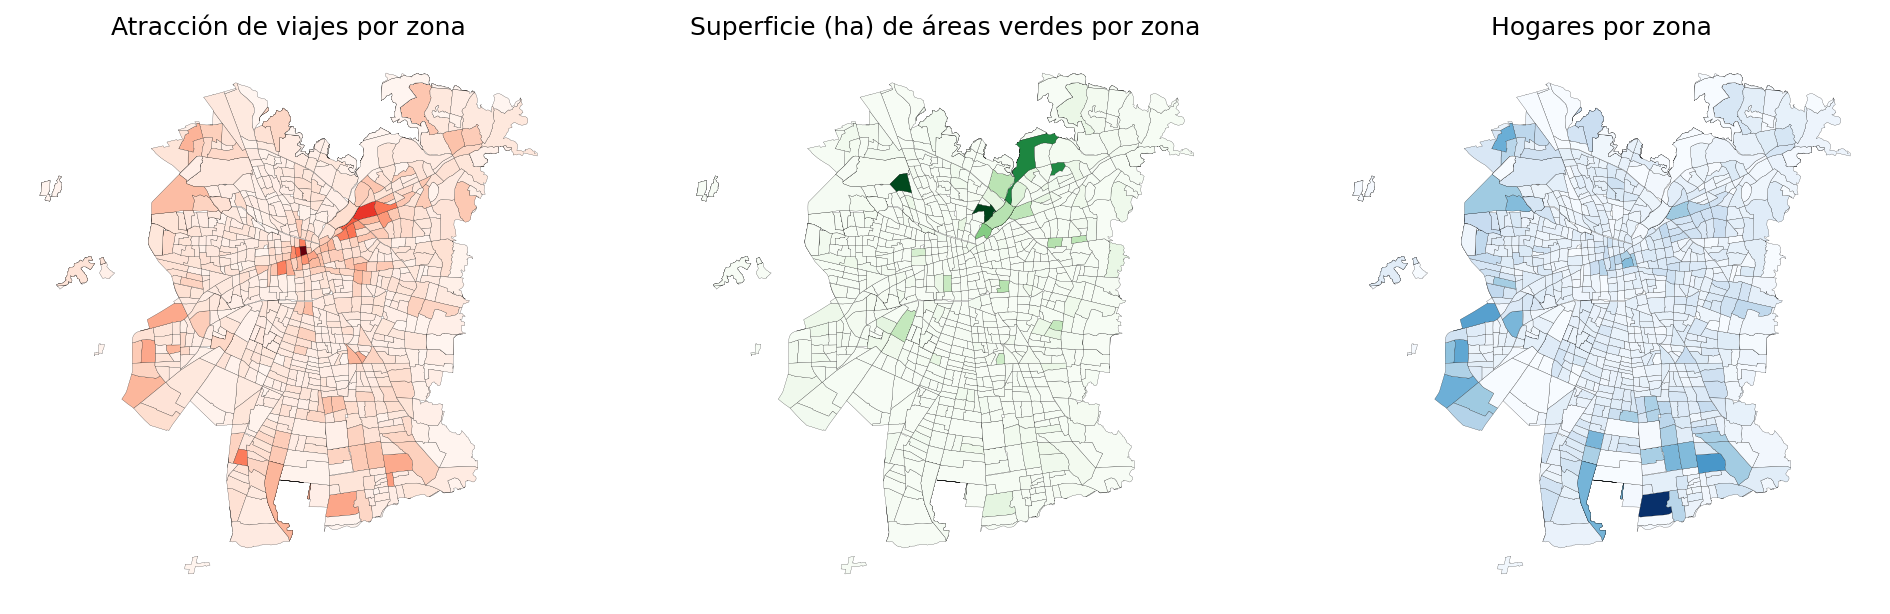

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(16, 10)) 

multiples[
    ["geometry", "atraccion"]
].plot(
    column="atraccion",
    cmap="Reds",
    ax=ax[0],
    edgecolor="black",
    linewidth=0.1,
)
multiples[
    ["geometry", "area_ha"]
].plot(
    column="area_ha",
    cmap="Greens",
    ax=ax[1],
    edgecolor="black",
    linewidth=0.1,
)
multiples[
    ["geometry", "FactorHogar"]
].plot(
    column="FactorHogar",
    cmap="Blues",
    ax=ax[2],
    edgecolor="black",
    linewidth=0.1,
)

ax[0].set_title("Atracción de viajes por zona")
ax[1].set_title("Superficie (ha) de áreas verdes por zona")
ax[2].set_title("Hogares por zona")
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
sns.despine()


Demosle pesos a la atraccion y los hogares y grafiquemos la diferencia

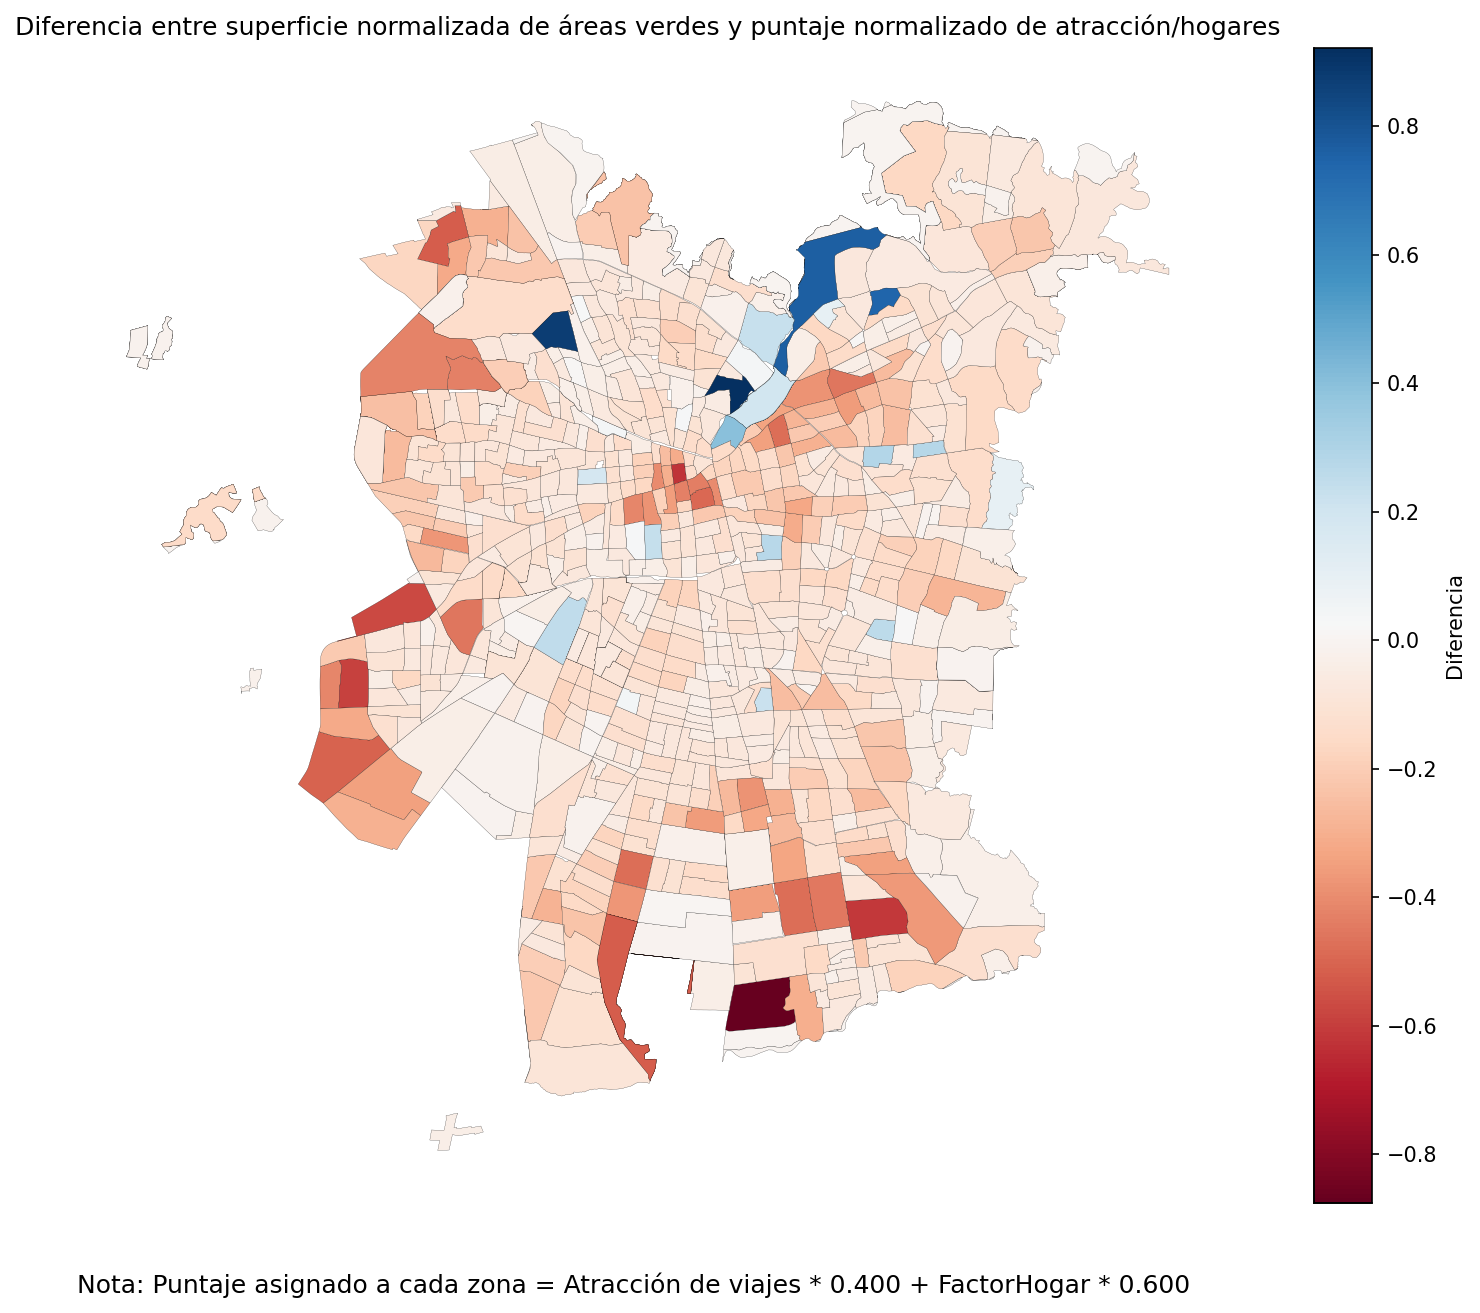

In [30]:
# damos pesos a la atraccion y a los hogares
PESO_ATRACTIVO = 0.4
PESO_HOGARES = 1 - PESO_ATRACTIVO

# sumamos los pesos
multiples["puntaje"] = multiples["atraccion"] / multiples["atraccion"].max() * PESO_ATRACTIVO + multiples["FactorHogar"] / multiples["FactorHogar"].max() * PESO_HOGARES

# normalizamos
multiples["puntaje_normalizado"] = multiples["puntaje"] / multiples["puntaje"].max()
multiples["area_ha_normalizado"] = multiples["area_ha"] / multiples["area_ha"].max()

# diferencia
multiples["diferencia"] = multiples["area_ha_normalizado"] - multiples["puntaje_normalizado"]

# graficamos
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
multiples.plot(
    column="diferencia",
    cmap="RdBu",
    ax=ax,
    edgecolor="black",
    linewidth=0.1,
    legend=True,
    legend_kwds={"label": "Diferencia"},
)
ax.set_title("Diferencia entre superficie normalizada de áreas verdes y puntaje normalizado de atracción/hogares")
ax.set_axis_off()
fig.text(0.5, 0.05, f"Nota: Puntaje asignado a cada zona = Atracción de viajes * {PESO_ATRACTIVO:.3f} + FactorHogar * {PESO_HOGARES:.3f}", ha='center', fontsize=12)
sns.despine()

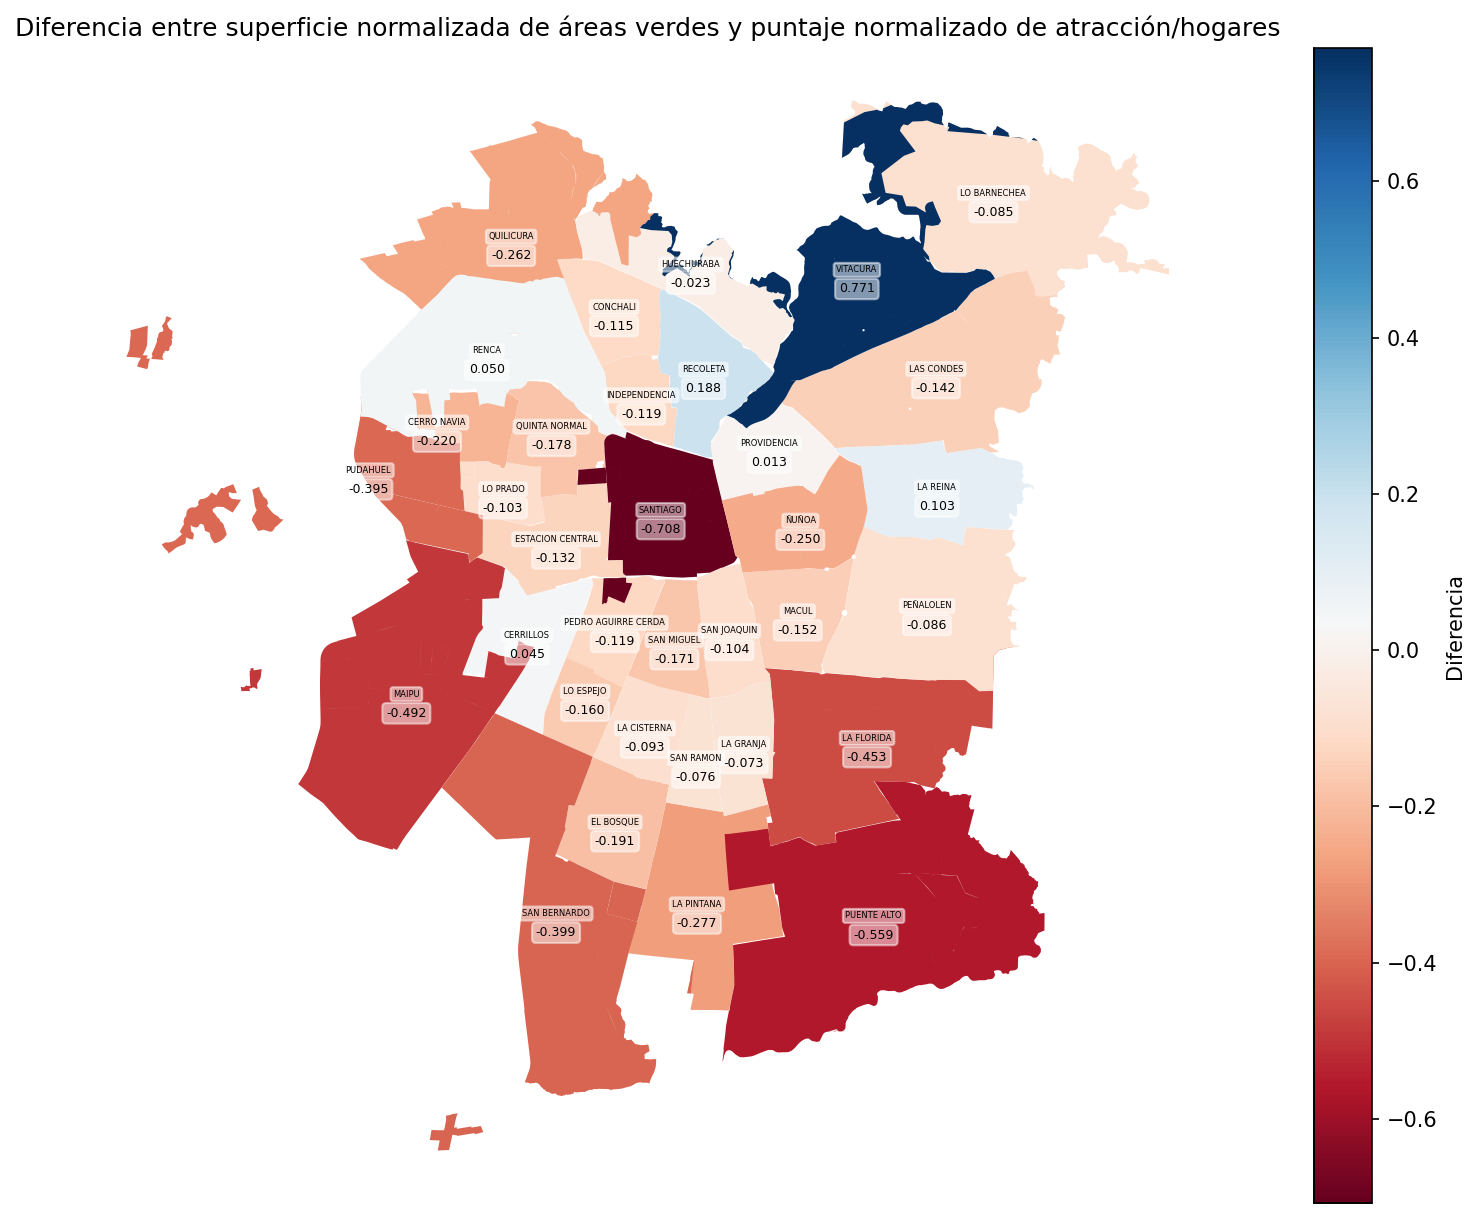

In [52]:
# pasemoslo a comunas
multiples_comunas = multiples.dissolve(
    by="Comuna", 
    aggfunc="sum")
# normalizamos
multiples_comunas["puntaje_normalizado"] = multiples_comunas["puntaje"] / multiples_comunas["puntaje"].max()
multiples_comunas["area_ha_normalizado"] = multiples_comunas["area_ha"] / multiples_comunas["area_ha"].max()
# diferencia
multiples_comunas["diferencia"] = multiples_comunas["area_ha_normalizado"] - multiples_comunas["puntaje_normalizado"]
# graficamos
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
multiples_comunas.plot(
    column="diferencia",
    cmap="RdBu",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Diferencia"},
)
for idx, row in multiples_comunas.iterrows():
    an = ax.annotate(
        idx,
        (row.geometry.centroid.x, row.geometry.centroid.y),
        horizontalalignment="center",
        fontsize=4,
        bbox=dict(boxstyle="round", alpha=0.5, color="white"),
    )
    ax.annotate(
        f"{row['diferencia']:.3f}",
        (an.get_position()[0], an.get_position()[1] - 0.007),
        horizontalalignment="center",
        fontsize=6,
        bbox=dict(boxstyle="round", alpha=0.5, color="white"),
    )


ax.set_title("Diferencia entre superficie normalizada de áreas verdes y puntaje normalizado de atracción/hogares")
ax.set_axis_off()
sns.despine()